In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Extending published ETVs for TIC 3311888

Check if the orbital decay indicated in https://ui.adsabs.harvard.edu/abs/2013A%26A...559A..22M/abstract can be found in TESS data

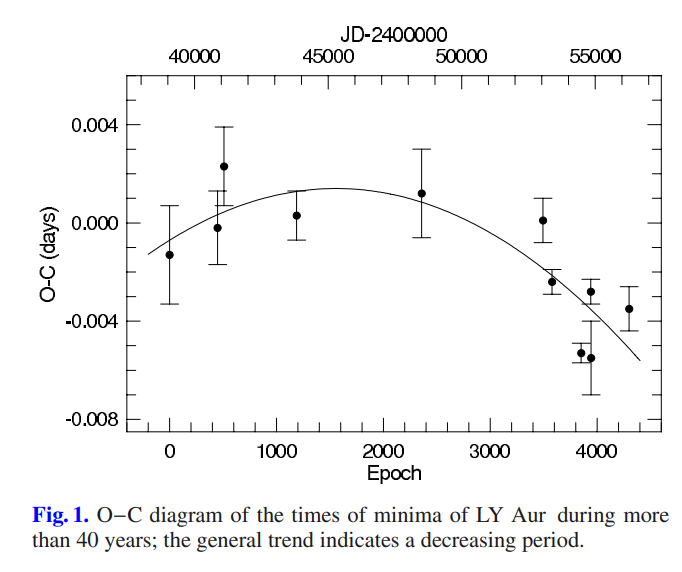


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 3311888

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()
lc_tess = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.select_flux("sap_flux").normalize())  # PDCSAP_FLUX actually distorted the LC
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now

# convert the time to HJD, so be aligned with the param in the paper
# coordiante from Gaia DR3 183255985260080896
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=dict(ra=82.42770711954, dec=35.37502715056), cache_dir=lk_download_dir, cache_key_suffix="sap_flux")

search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance     proposal_id     
                                  s                 arcsec                      
--- -------------- ---- ------ ------- ----------- -------- --------------------
  0 TESS Sector 19 2019   SPOC     120     3311888      0.0              G022062
  1 TESS Sector 43 2021   SPOC     120     3311888      0.0 G04074_G04171_G04234
  2 TESS Sector 44 2021   SPOC     120     3311888      0.0 G04074_G04171_G04234
  3 TESS Sector 45 2021   SPOC     120     3311888      0.0 G04074_G04171_G04234
  4 TESS Sector 59 2022   SPOC     120     3311888      0.0 G05036_G05143_G05003
  5 TESS Sector 73 2023   SPOC     120     3311888      0.0        G06037_G06057

103363

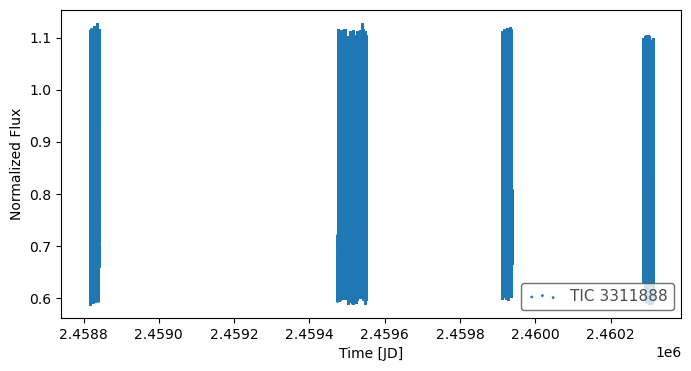

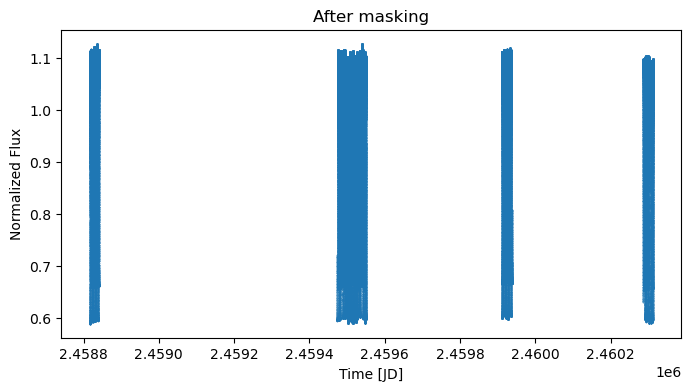

In [17]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

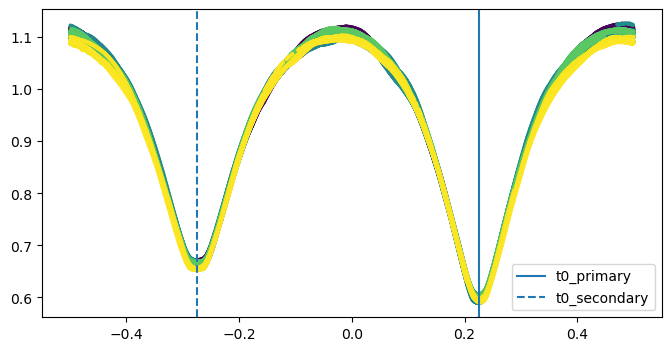

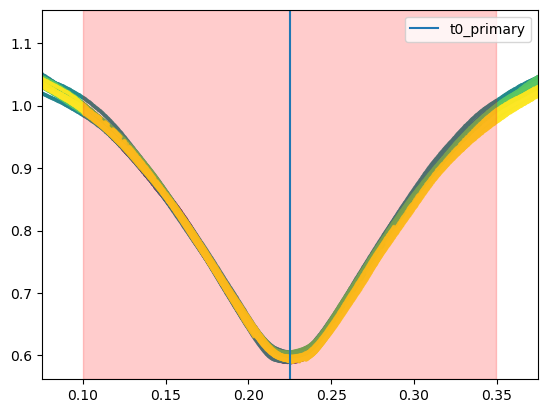

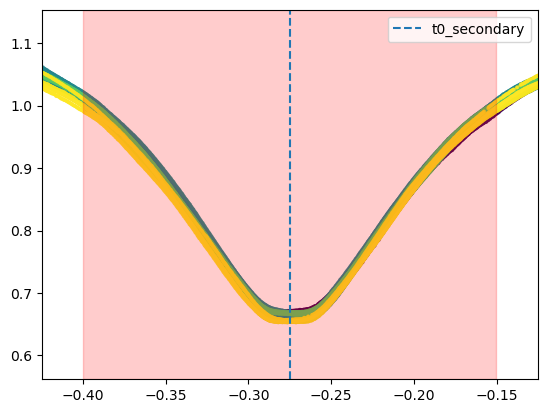

In [18]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
period = 4.0024932  # from the paper

# t0_primary_hjd = 2439061.4646  # from the paper
# t0_primary = Time(t0_primary_hjd, format="jd", scale="utc").to_value(format="btjd")
t0_primary = 2439061.4646  # from the paper, in HJD, the lc has been converted to HJD
t0_secondary = t0_primary + period  / 2

duration_hr_primary = 24 
duration_hr_secondary = 24

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   2458813.768542 0.22499999998813092
window_width_p (phase): 0.07495328161956652
Secondary: 2458815.7697886 -0.275000000025318
window_width_s (phase): 0.07495328161956652


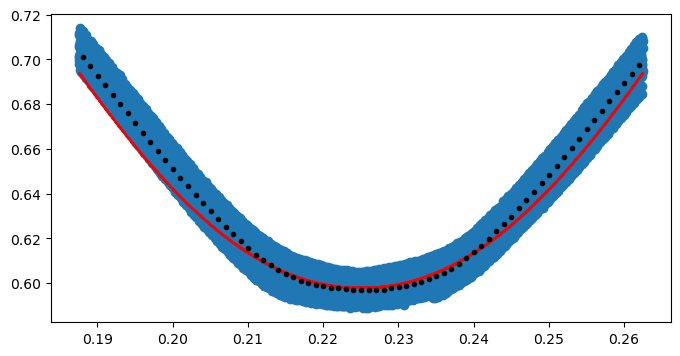

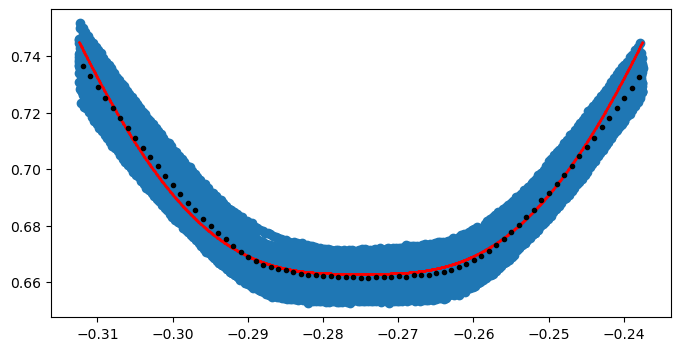

In [126]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
# window_width_p = 1.2 * duration_hr_primary / 24 / period
# the above widnow (1.2X, ~28.8 hours) seems too to too big for cosh model, usu a smaller one 
window_width_p = 0.3 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.3 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase

# start vals for the long (28.8 hour) window
# start_vals = [1.05, -0.44, midpoint_p, 0.065, 0.95]
# start_vals_s = [1.05, -0.38, midpoint_s, 0.065, 0.95]

start_vals = [0.93, -0.332, midpoint_p, 0.045, 1.05]
start_vals_s = [0.93, -0.267, midpoint_s, 0.035, 1.55]


# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)


emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.35it/s]


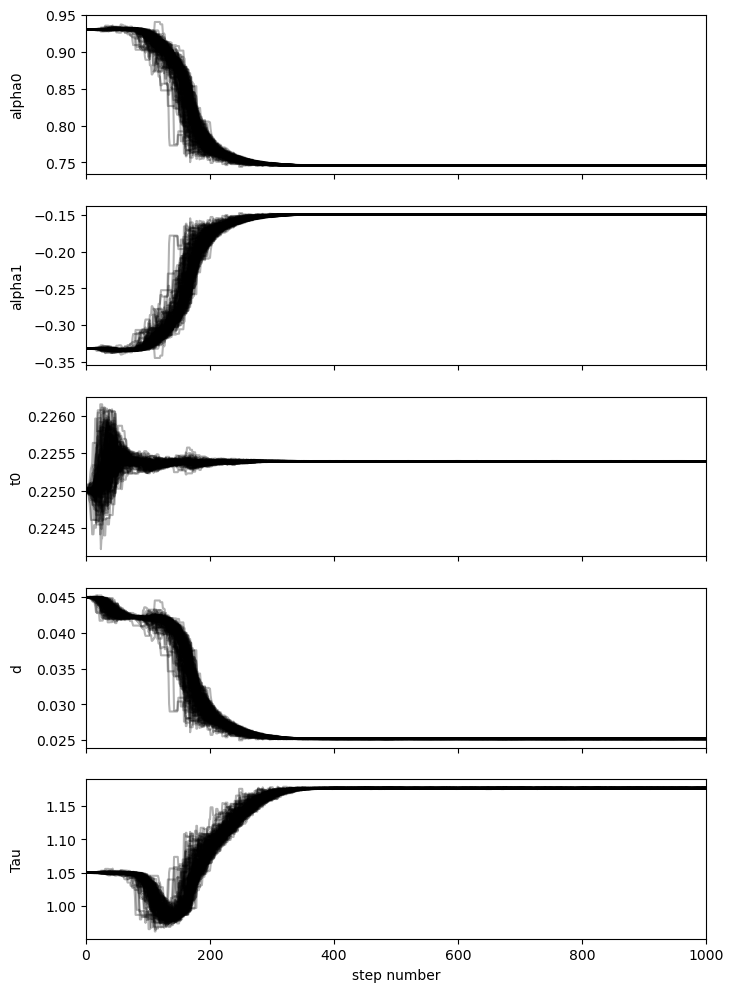

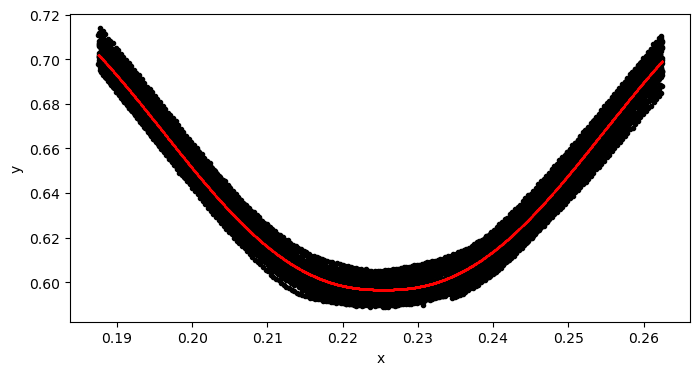

In [102]:
men_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.70it/s]


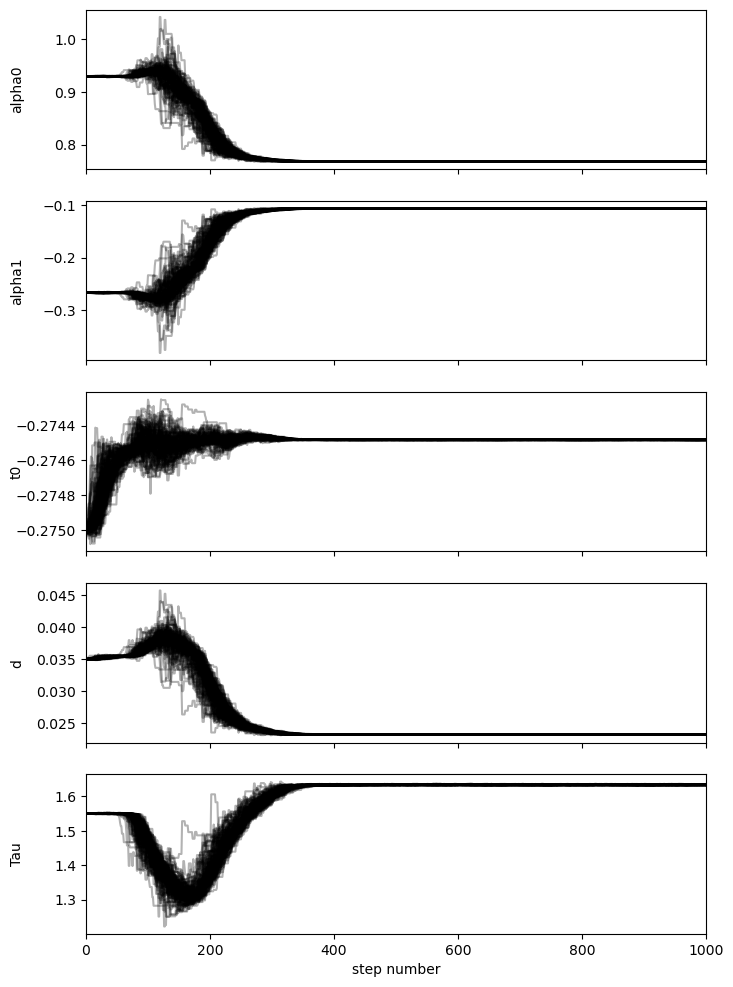

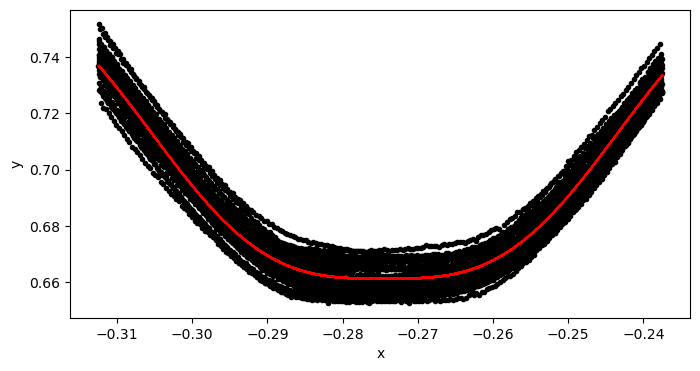

In [125]:
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)

Note: The initial fitted model seems to be too V-shaped (`Tau` is too small).
- the truncated eclipses are in a 28.8 hour window, possibly too long for the cosh model
- use a much smaller window fo better fit the relatively flat portion around minimum

---

The fitted model with large truncaed window for reference:

Primary eclipses:

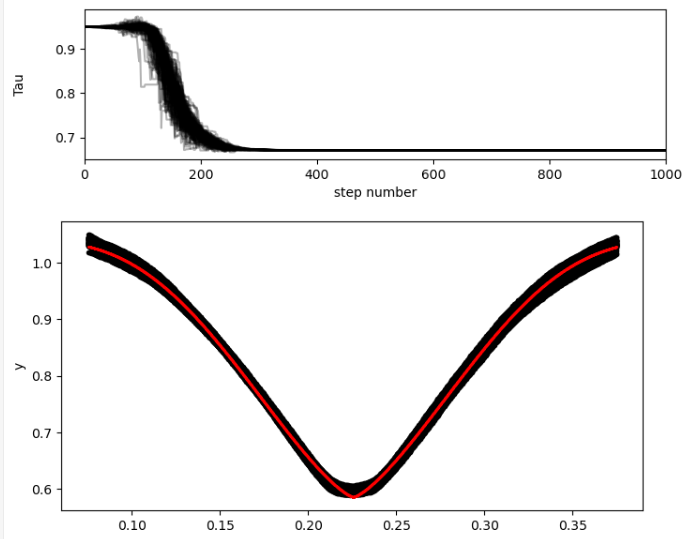


Secondary eclipses:

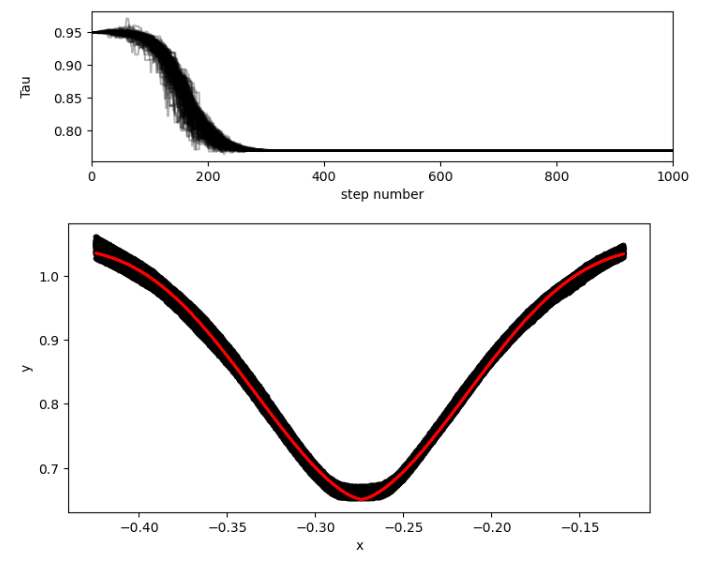


emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:23<00:00,  4.92it/s]


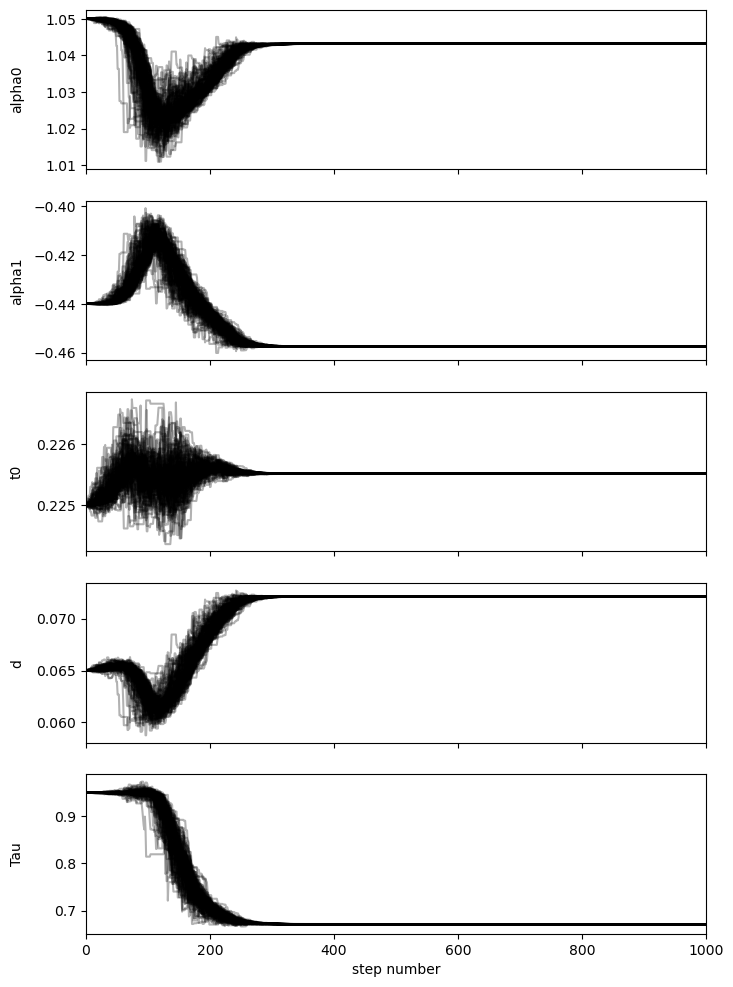

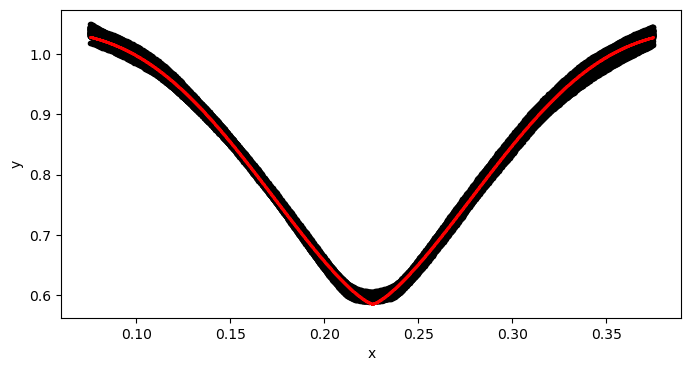

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:02<00:00,  5.48it/s]


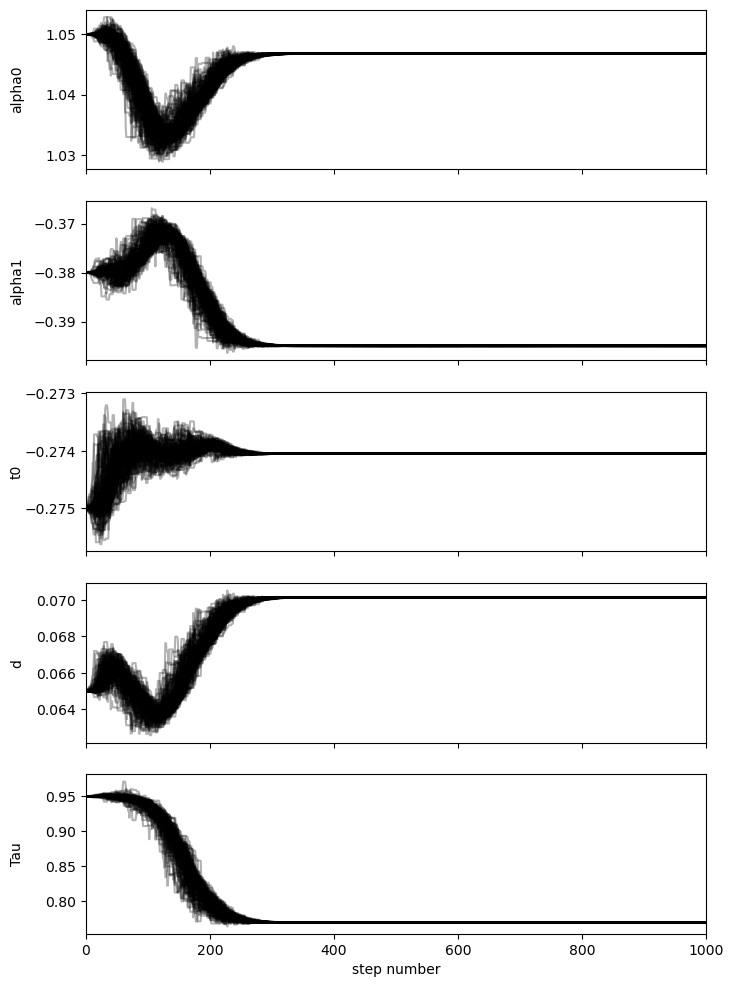

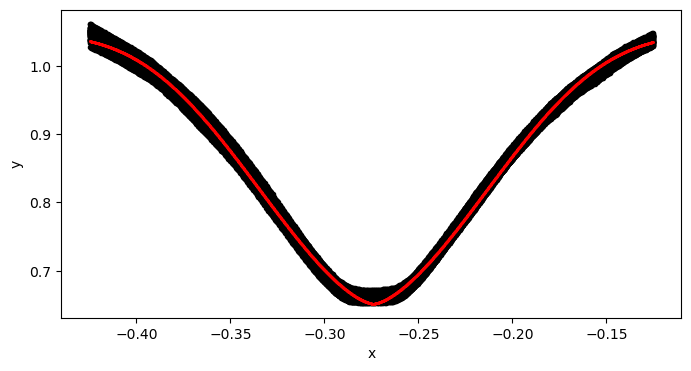

In [26]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    # based on 28.8 hour window
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0431614605280746, -0.45754054945818623, 0.22551212563088013, 0.07214412798931916, 0.6712295271461093
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0467949002210326, -0.39497480291586046, -0.27405084439129557, 0.07014593224301373, 0.768874828269765

    # revised fit based much shorter (7.2 hour) window for the clipped eclipse
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0431614605280746, -0.1492641130989216, 0.22551212563088013, 0.02516763999961122, 1.1770741190796947
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.7680392547126925, -0.10652071650576417, -0.2744825026795723, 0.023253667608004167, 1.6339407856510089

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [127]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0431614605280746, -0.1492641130989216, 0.22551212563088013, 0.02516763999961122, 1.1770741190796947
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.7680392547126925, -0.10652071650576417, -0.2744825026795723, 0.023253667608004167, 1.6339407856510089


373

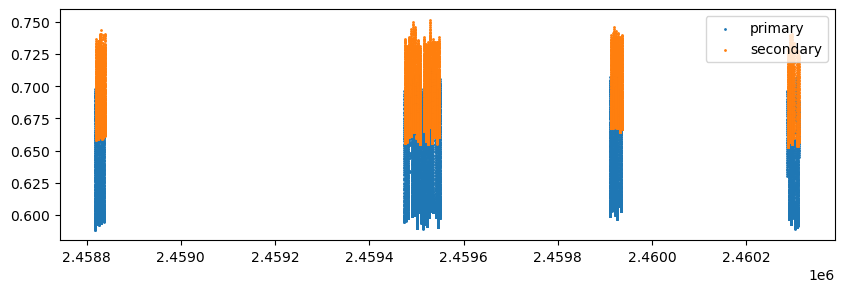

In [128]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

2458813.768542 4.0024932 2458813.768542


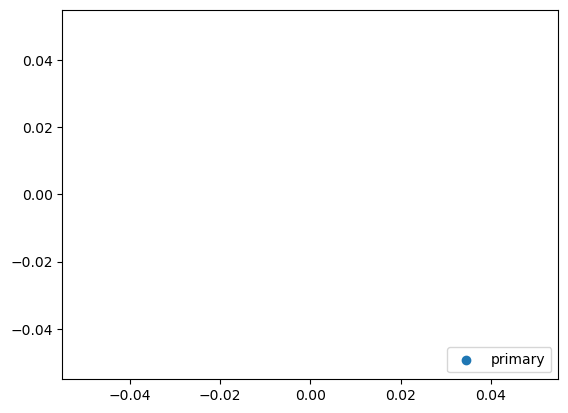

2458813.768542 4.0024932 2458817.7710352


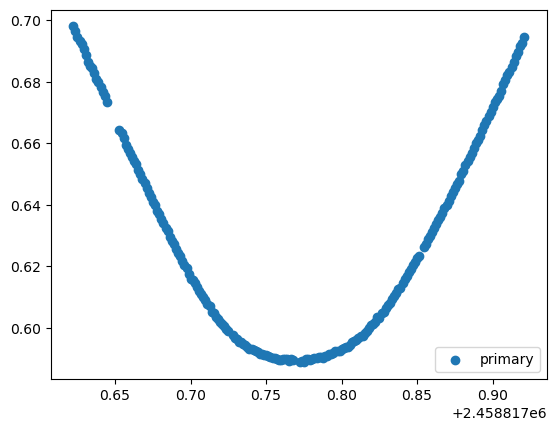

2458813.768542 4.0024932 2458821.7735284


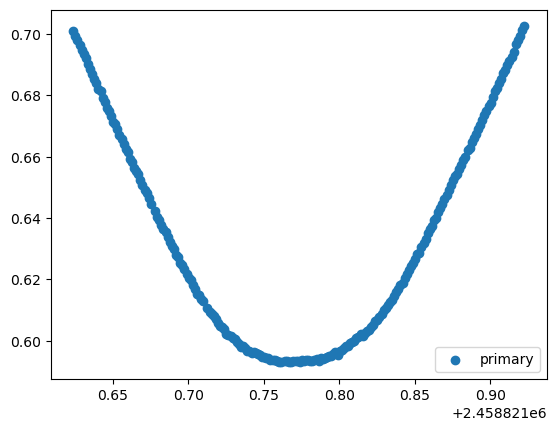

2458815.7697886 4.0024932 2458815.7697886


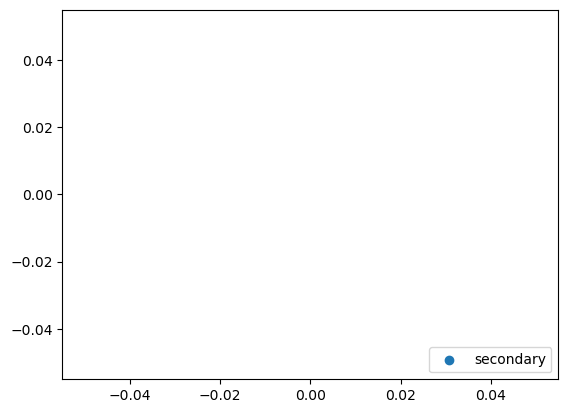

2458815.7697886 4.0024932 2458819.7722818


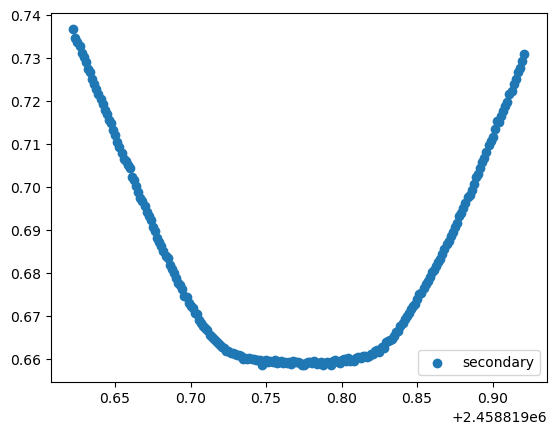

2458815.7697886 4.0024932 2458823.774775


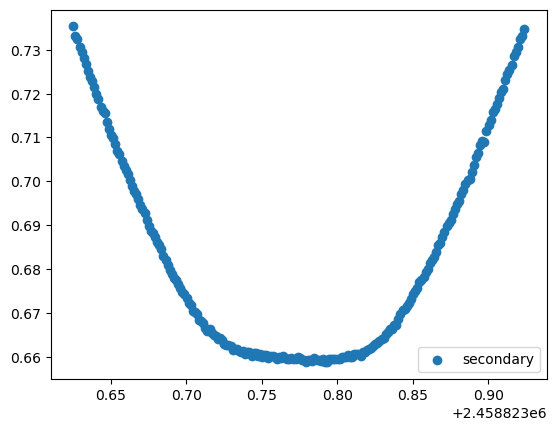

In [129]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
2458829.7785148 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.31it/s]


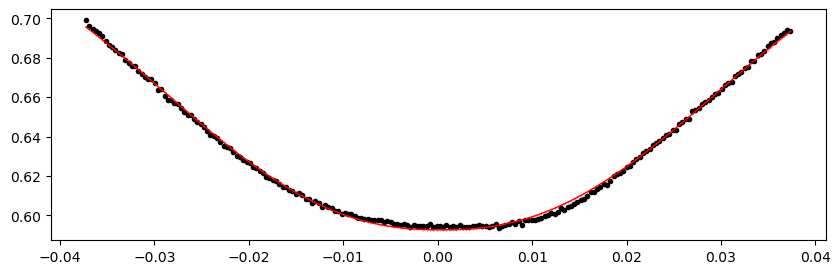

2458833.781008 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.62it/s]


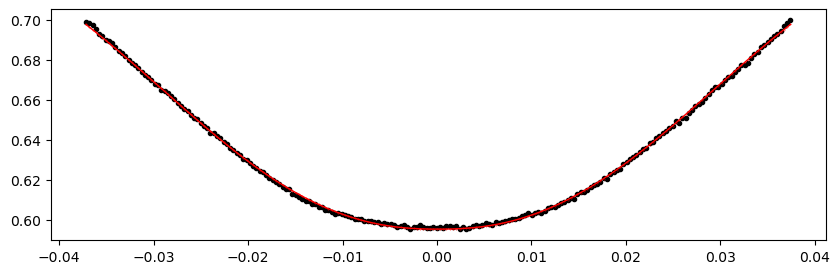

2458837.7835012 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.95it/s]


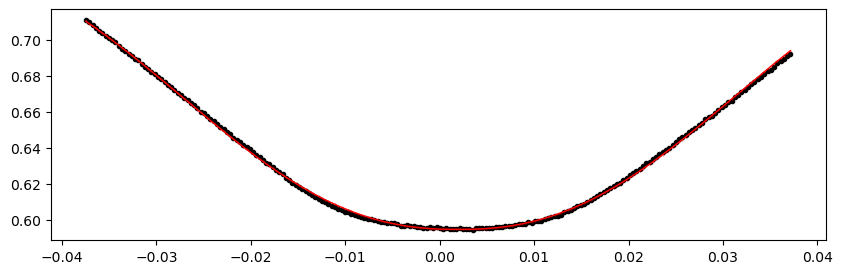

2459474.17992 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.93it/s]


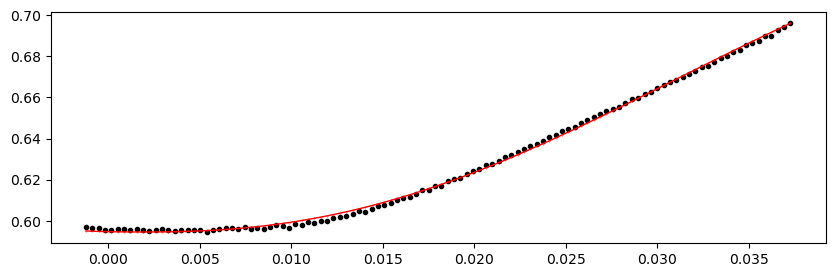

2459478.1824132 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.69it/s]


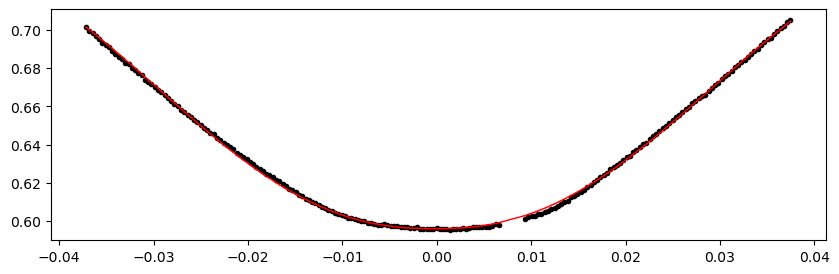

2459482.1849064003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.21it/s]


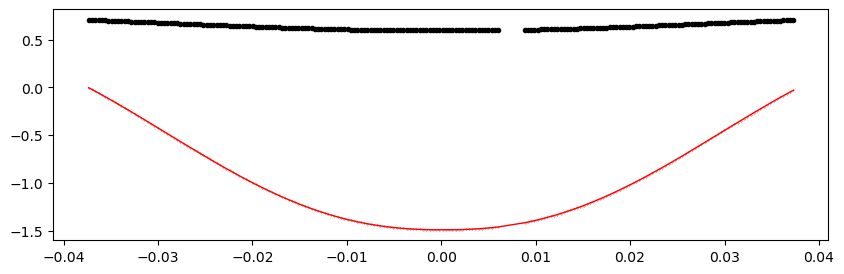

2459486.1873996 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.08it/s]


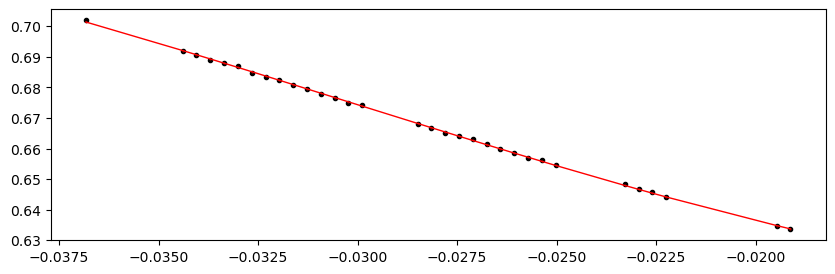

2459490.1898928 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.51it/s]


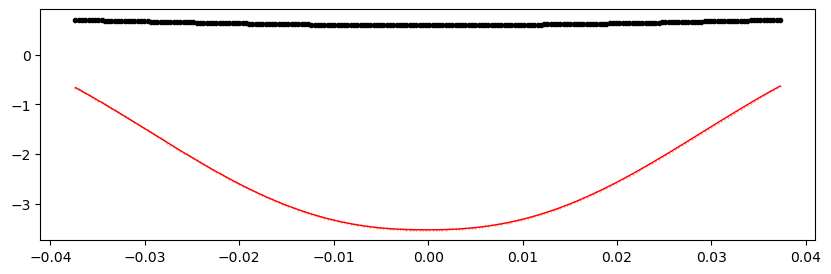

2459494.192386 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.90it/s]


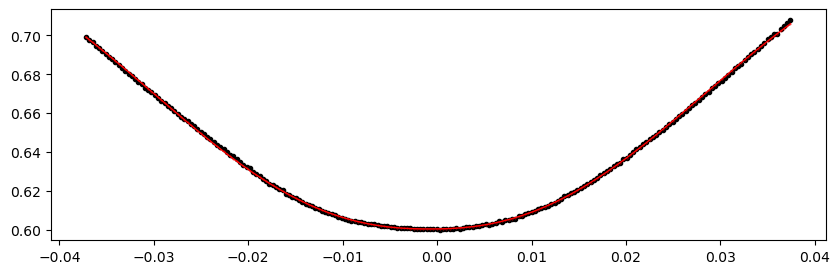

2459498.1948792003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.08it/s]


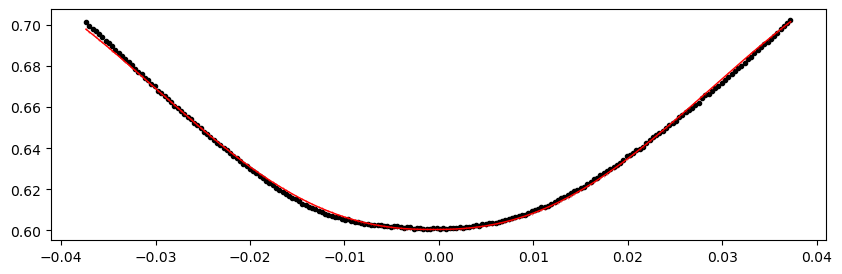

2459502.1973724 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.23it/s]


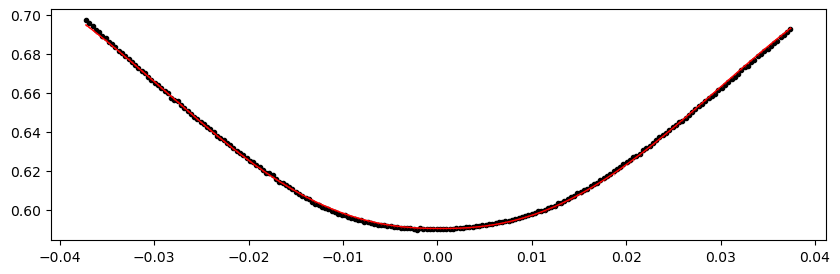

2459506.1998656 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.25it/s]


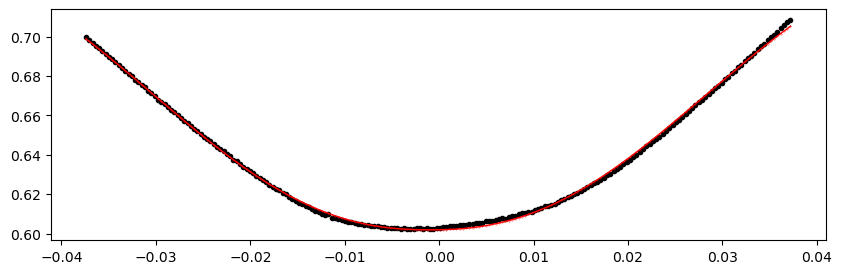

2459510.2023588 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.43it/s]


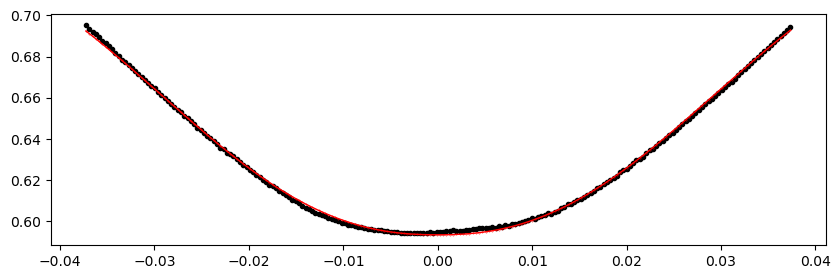

2459514.204852 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.34it/s]


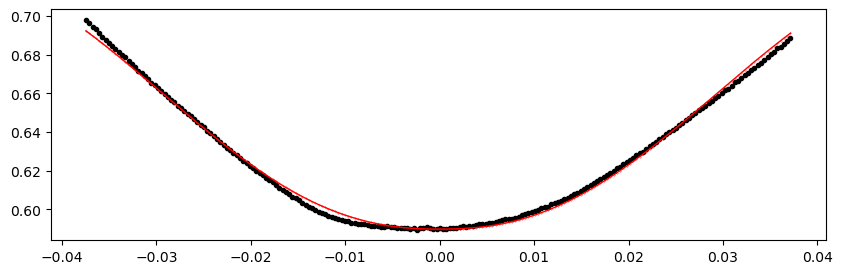

2459518.2073452002 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.90it/s]


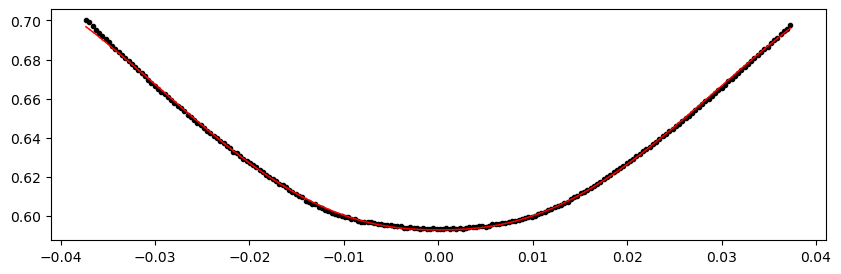

2459522.2098384 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.18it/s]


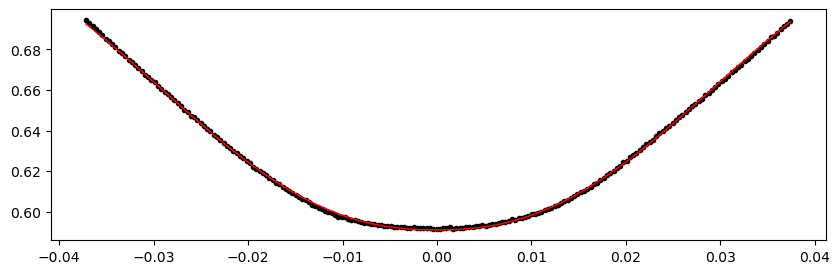

2459526.2123316 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.91it/s]


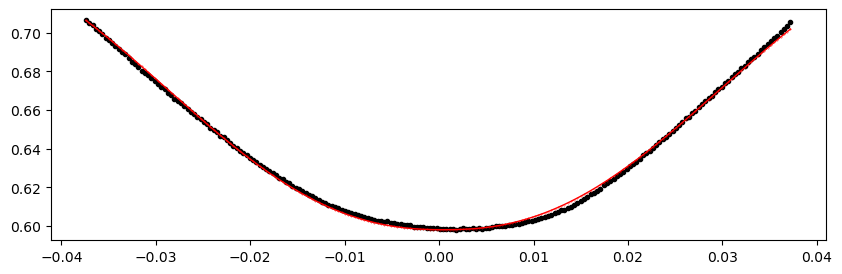

2459530.2148248 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.78it/s]


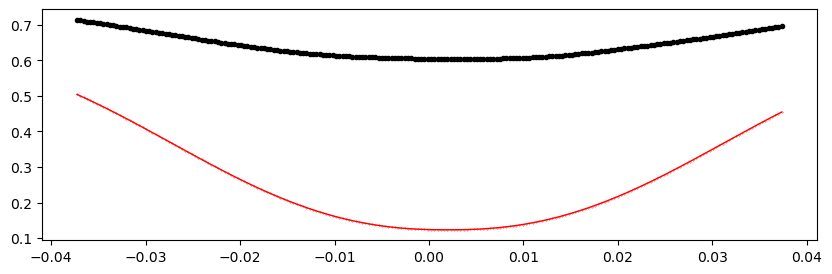

2459534.2173180003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 293.77it/s]


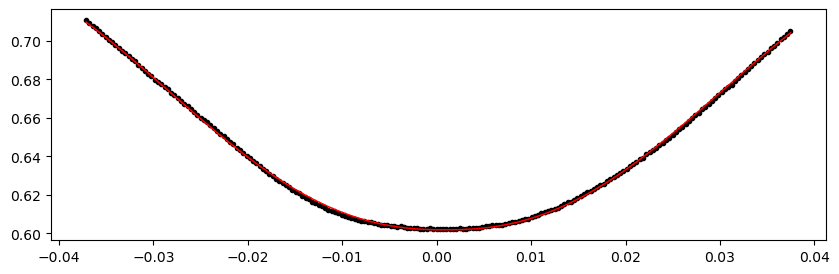

2459542.2223044 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.97it/s]


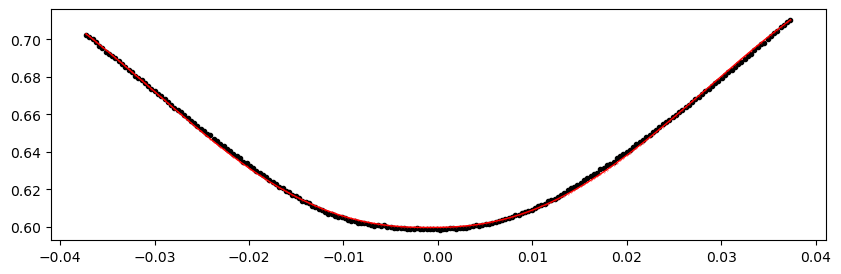

2459546.2247976 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.46it/s]


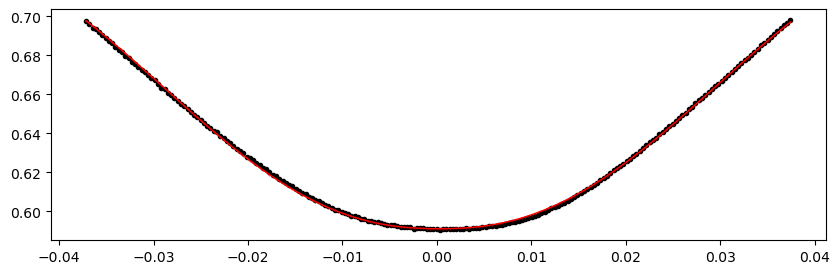

2459550.2272908003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.11it/s]


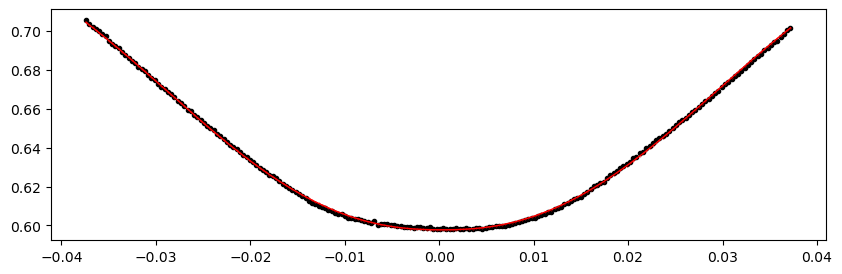

2459910.4516788 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.13it/s]


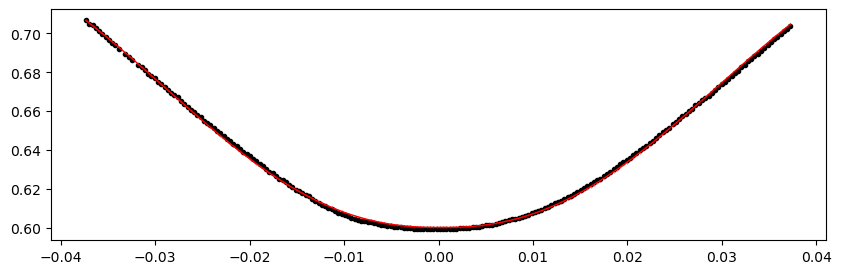

2459914.4541720003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.97it/s]


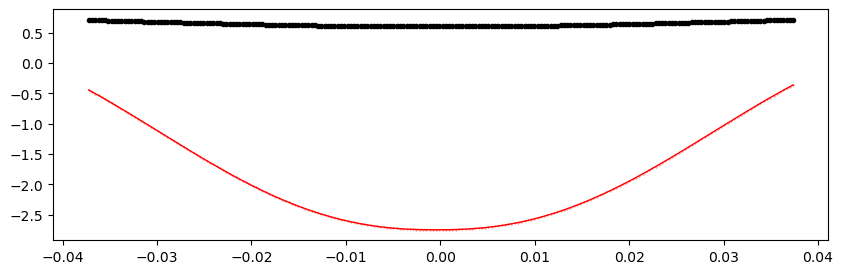

2459918.4566652 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.31it/s]


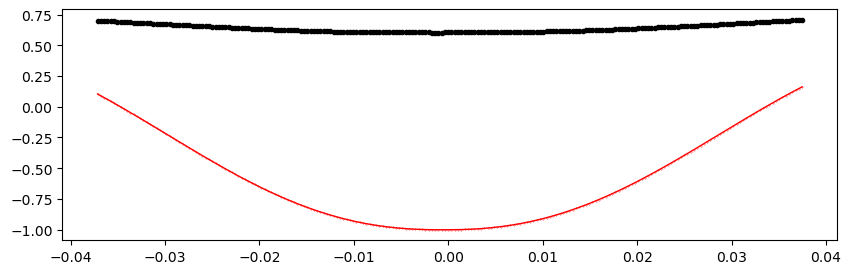

2459922.4591584 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.48it/s]


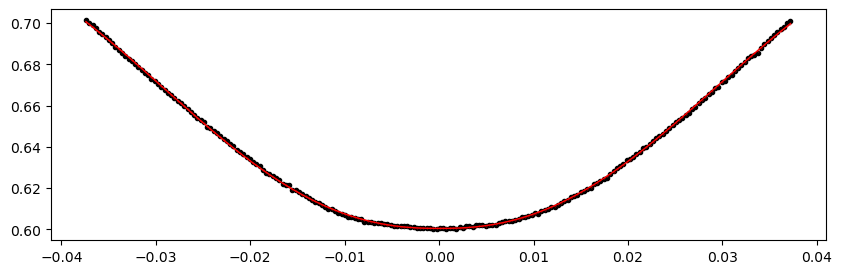

2459926.4616516 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.70it/s]


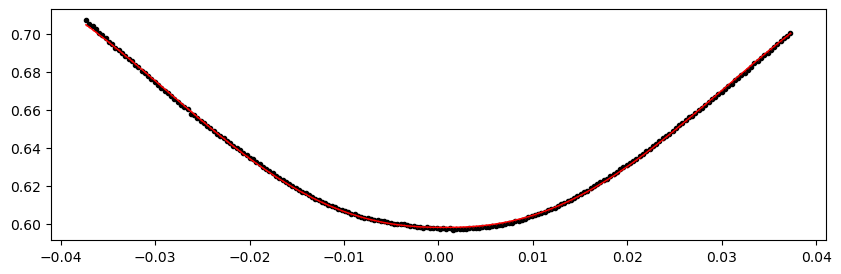

2459930.4641448003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.14it/s]


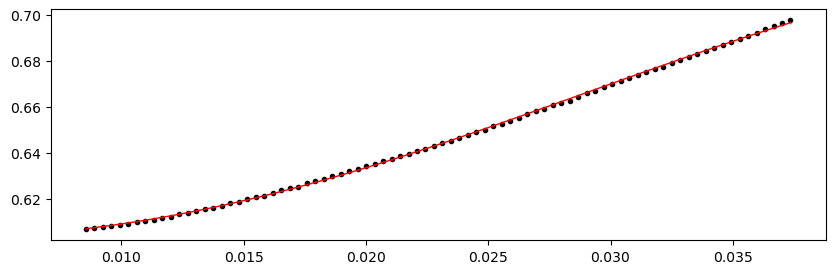

2459934.466638 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.41it/s]


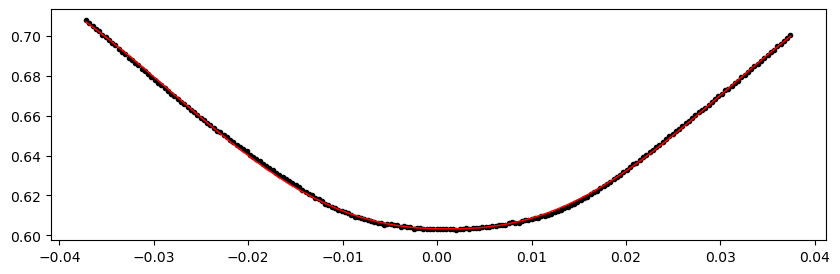

2460286.6860396 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.19it/s]


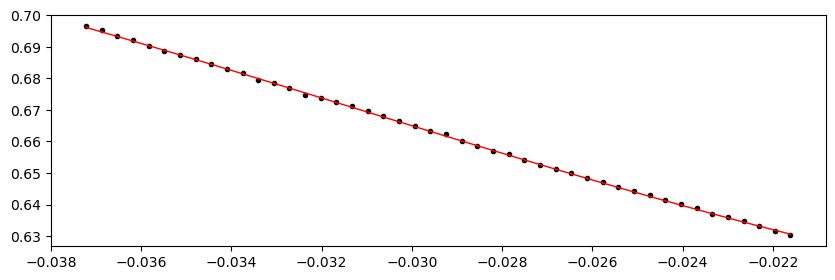

2460290.6885328 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.28it/s]


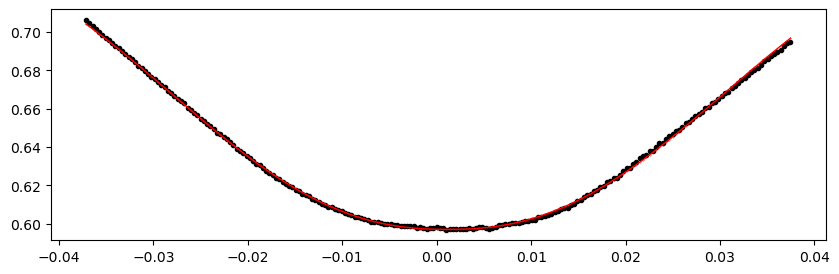

2460294.6910260003 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.27it/s]


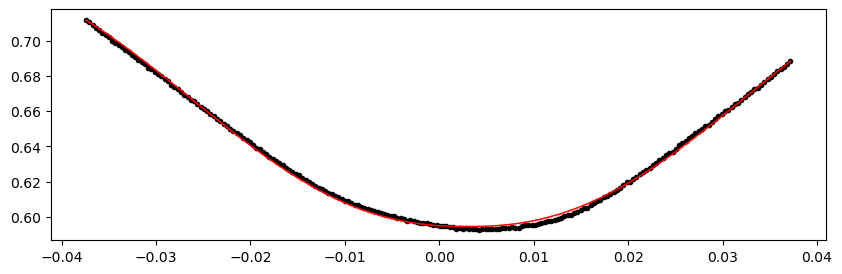

2460298.6935192 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.78it/s]


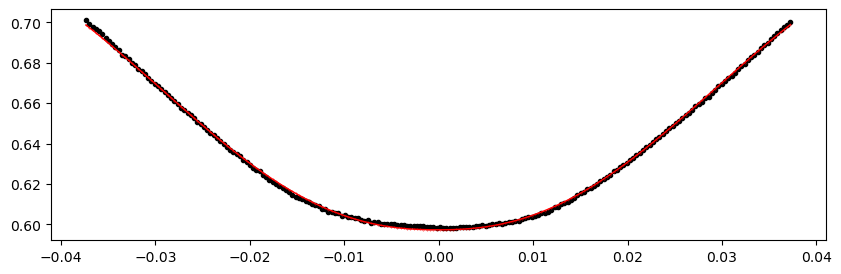

2460302.6960124 1.0431614605280746 -0.1492641130989216 0.22551212563088013


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.16it/s]


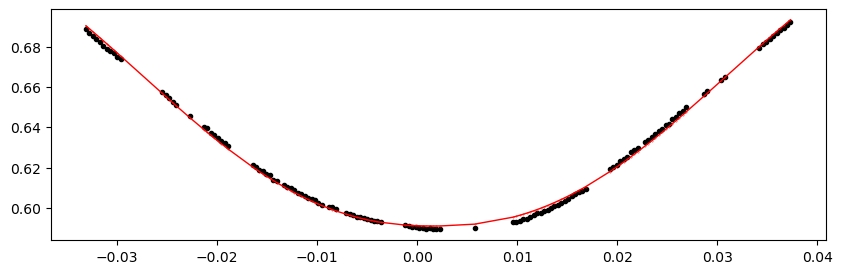

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
2458831.7797614 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.88it/s]


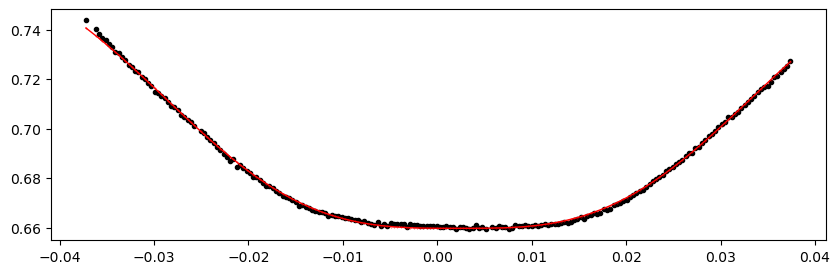

2458835.7822546 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.01it/s]


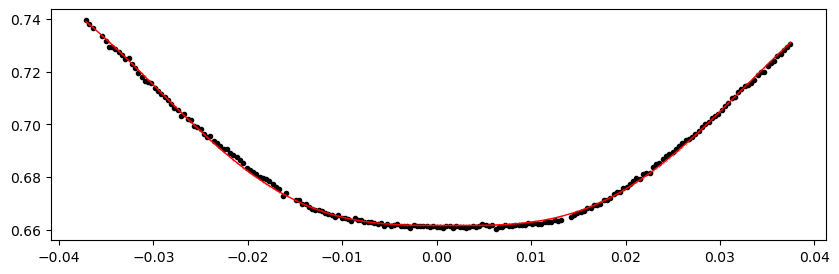

2458839.7847478 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.35it/s]


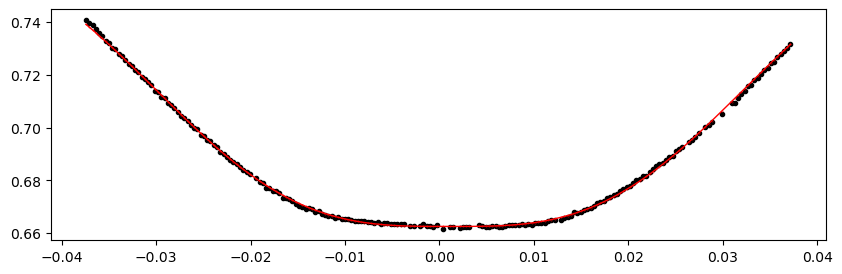

2459476.1811666 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.88it/s]


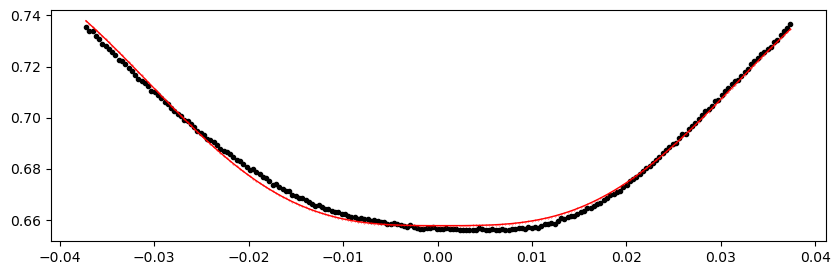

2459480.1836598 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.68it/s]


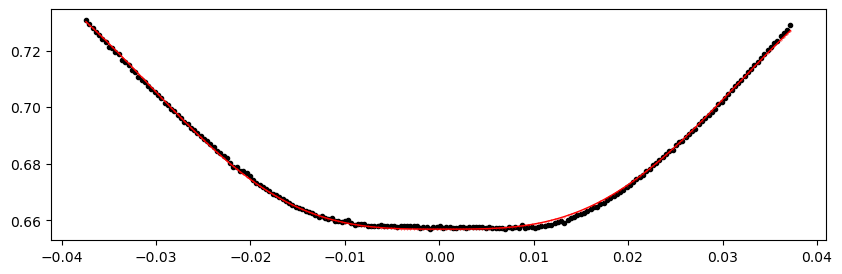

2459484.186153 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.95it/s]


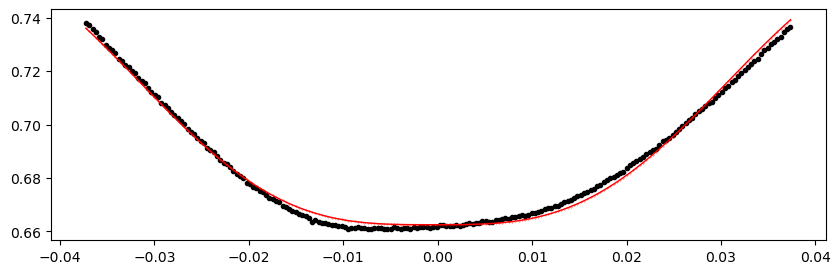

2459488.1886462 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.95it/s]


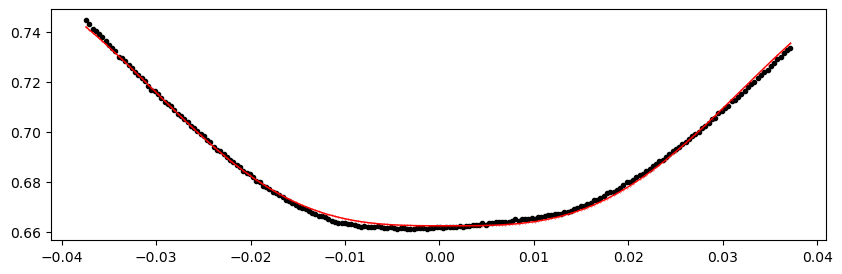

2459492.1911394 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.10it/s]


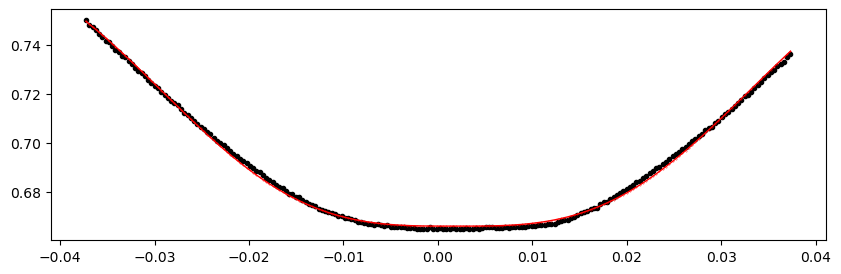

2459496.1936326 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.44it/s]


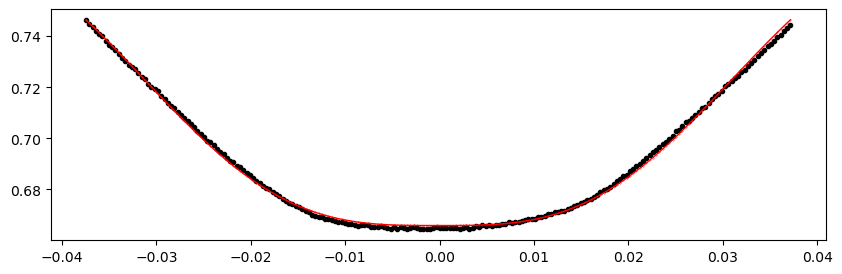

2459500.1961258003 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.27it/s]


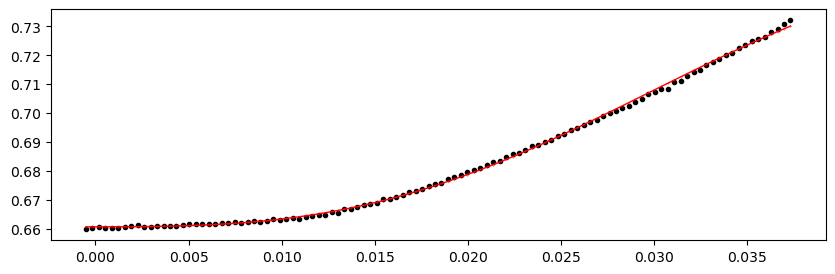

2459504.198619 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.90it/s]


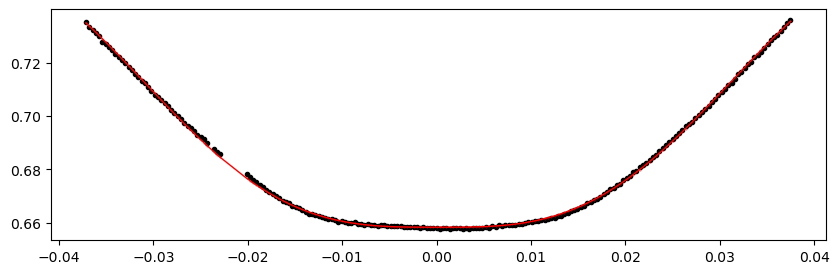

2459508.2011122 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.38it/s]


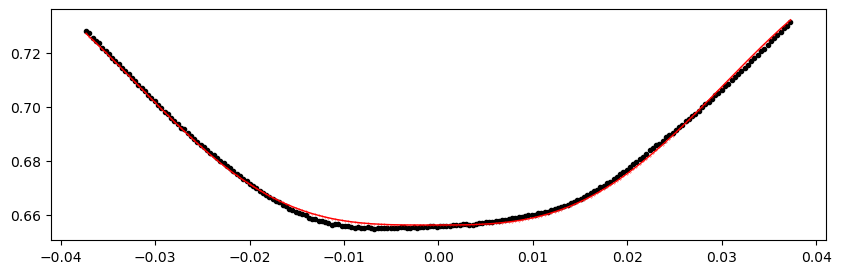

2459516.2060986 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.76it/s]


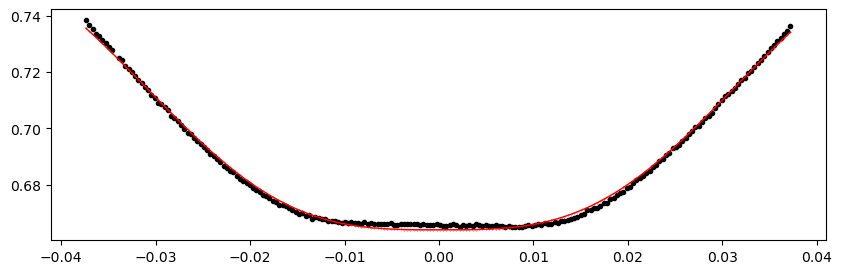

2459520.2085918 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.95it/s]


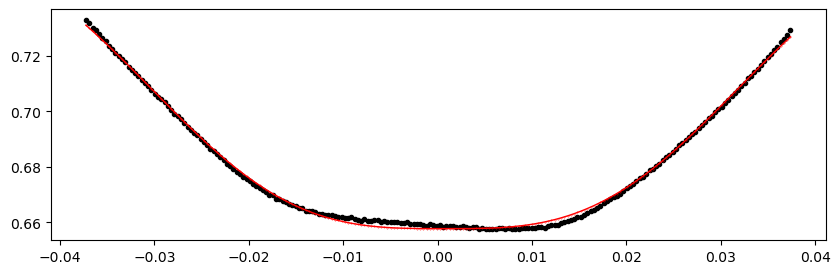

2459524.211085 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.01it/s]


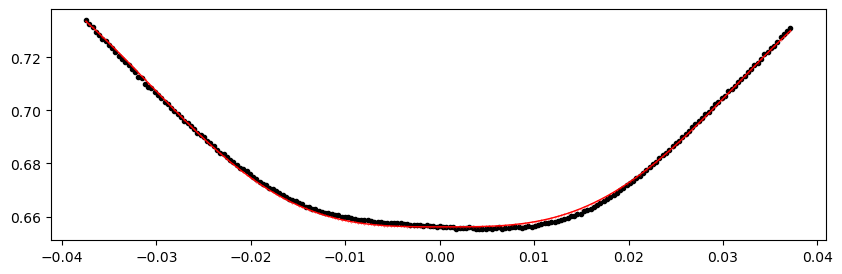

2459528.2135782 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.31it/s]


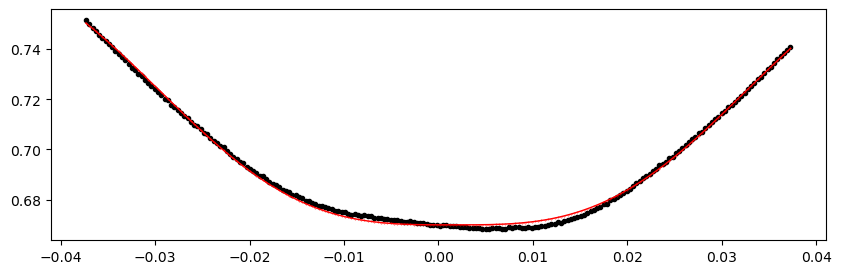

2459532.2160714 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.00it/s]


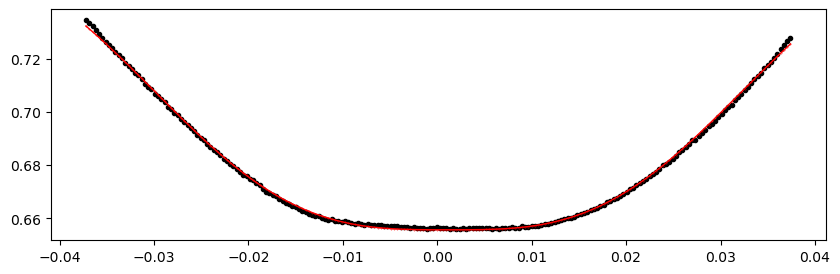

2459536.2185646 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.53it/s]


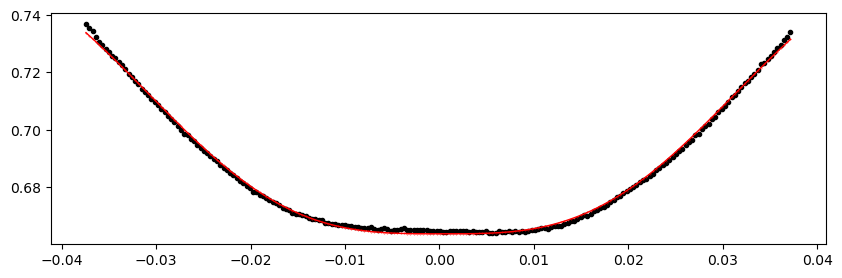

2459540.2210578 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.18it/s]


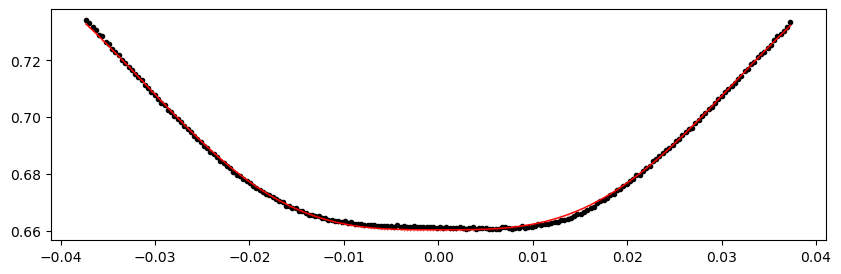

2459544.223551 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.32it/s]


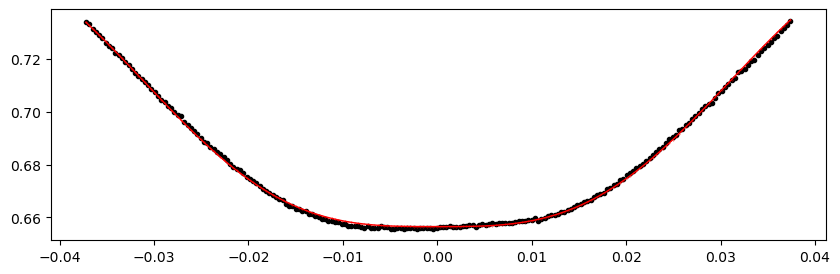

2459548.2260442 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.39it/s]


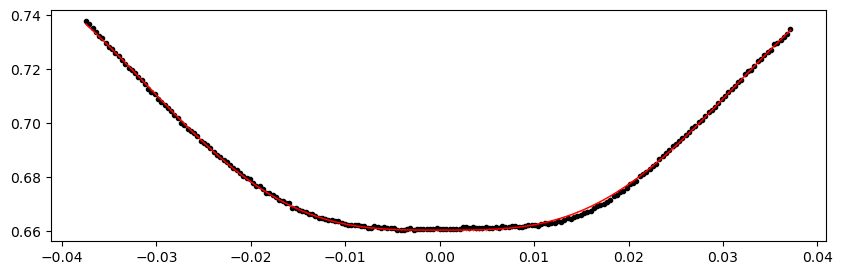

2459912.4529254 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.53it/s]


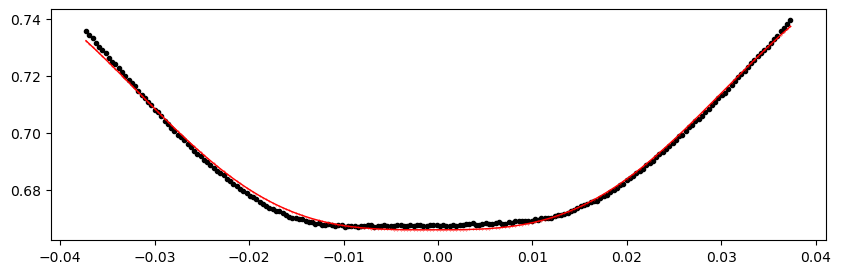

2459916.4554186002 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.75it/s]


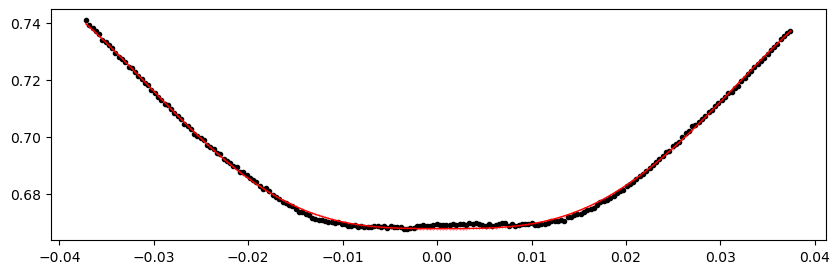

2459920.4579118 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.59it/s]


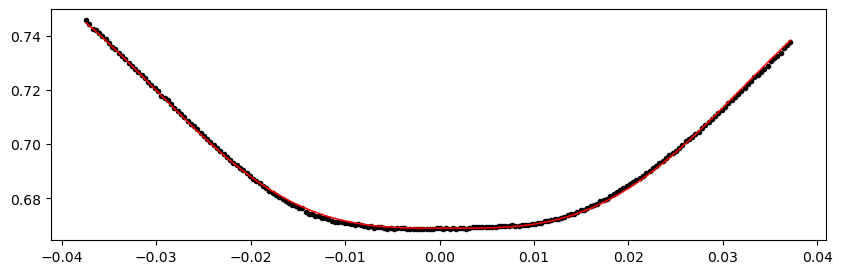

2459924.460405 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.01it/s]


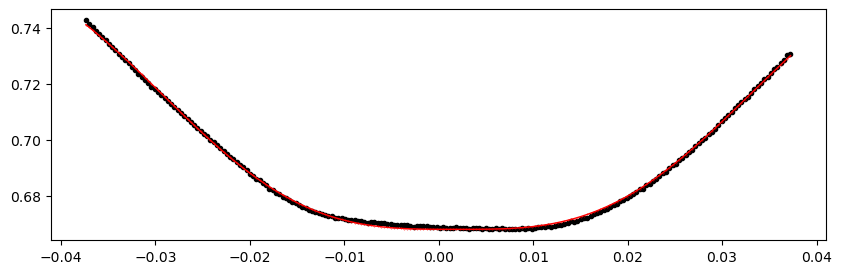

2459928.4628982 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.05it/s]


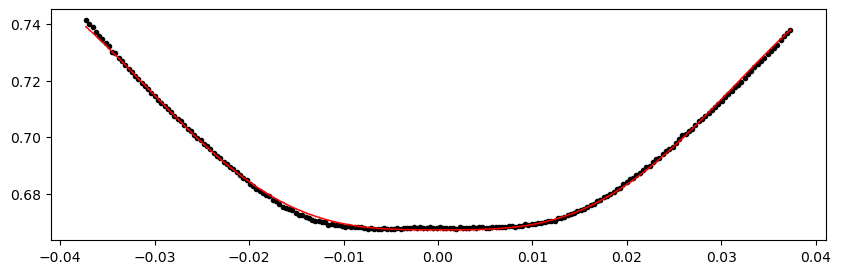

2459932.4653914003 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.62it/s]


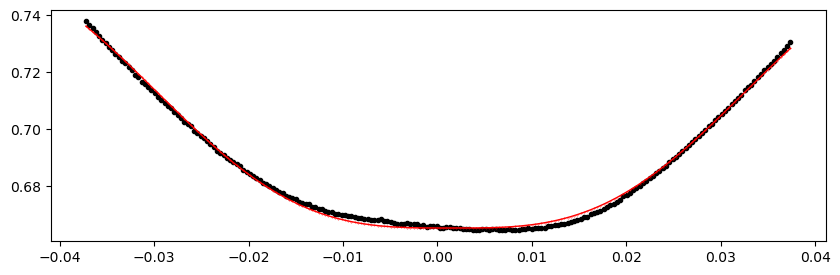

2459936.4678846 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.88it/s]


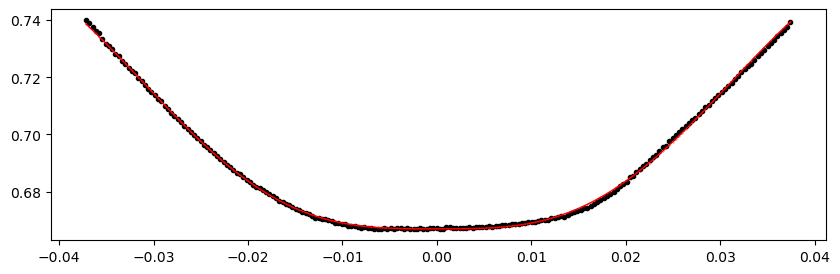

2460288.6872862 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.22it/s]


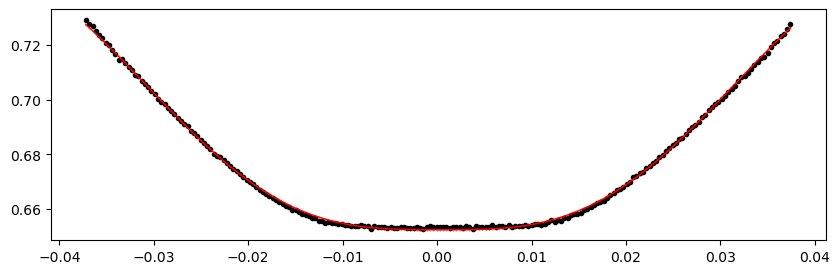

2460292.6897794 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 289.77it/s]


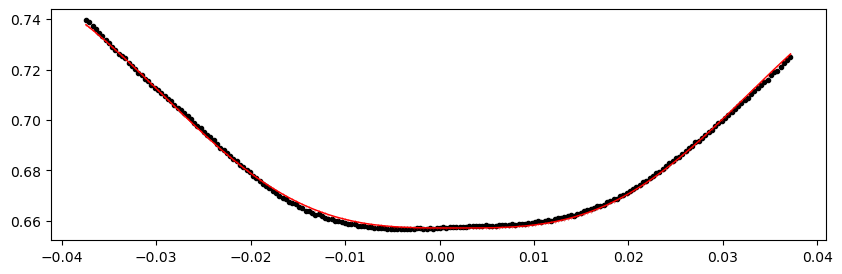

2460296.6922726003 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 298.15it/s]


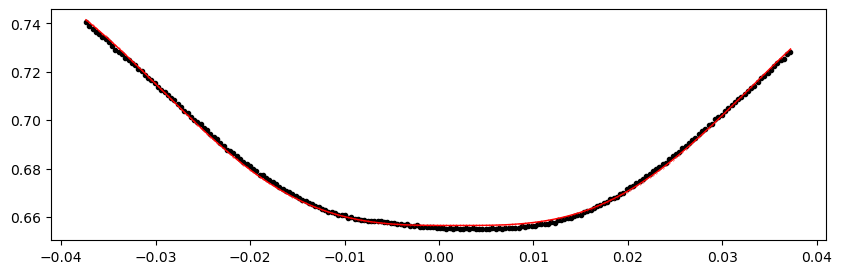

2460300.6947658 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.99it/s]


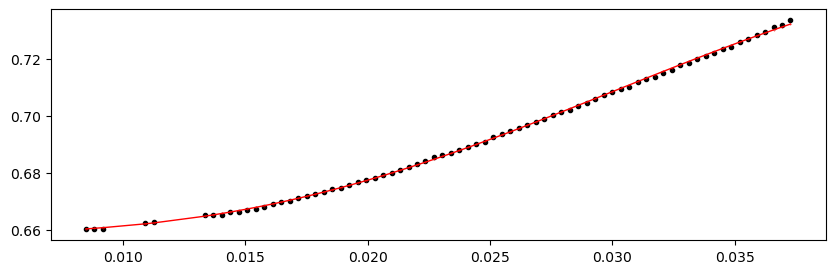

In [135]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")


Fitting individual secondary eclipses...
Creating new manifest file
2458819.7722818 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.48it/s]


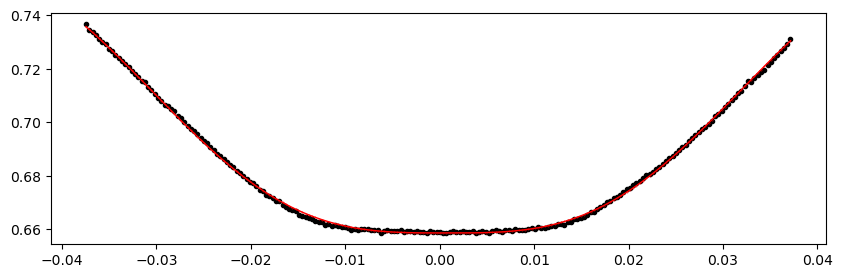

2458823.774775 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.41it/s]


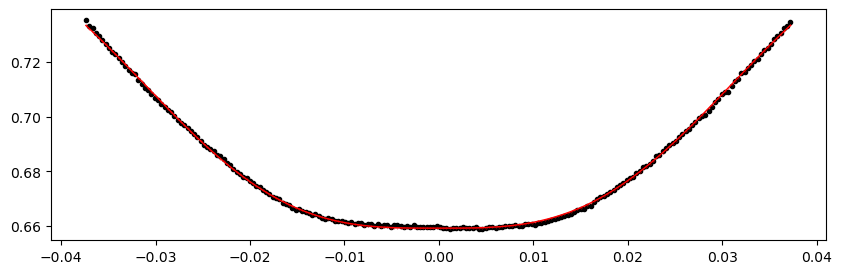

2458827.7772682 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.80it/s]


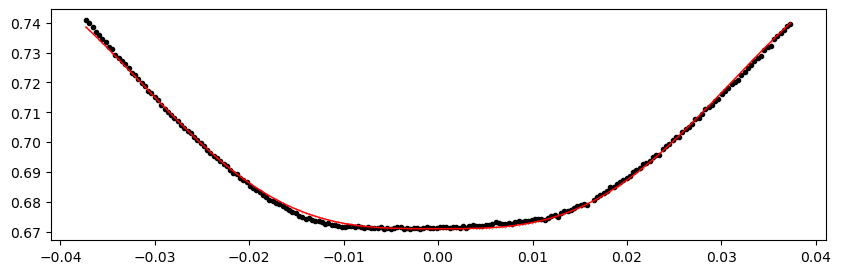

2458831.7797614 0.7680392547126925 -0.10652071650576417 -0.2744825026795723


 54%|██████████████████████████████▎                         | 5414/10000 [00:17<00:14, 315.90it/s]


KeyboardInterrupt: 

## ETV O-C plot

Using a smaller eclipse window (7.2 hour) for cosh model does not change the result (compared with the larger window of 28.8 hour around minima)

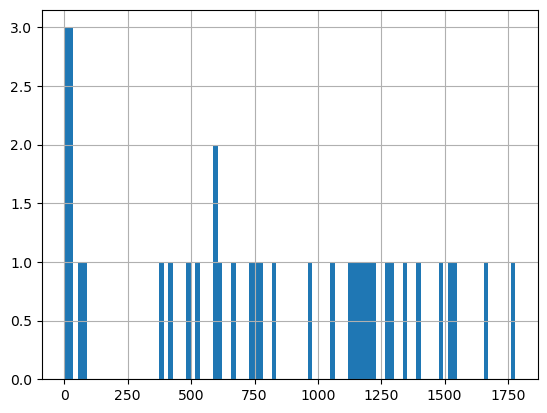

In [138]:
# to help to  filter out valeus with huge error
in_df_primary.std_mins.hist(bins=100)
plt.show()
# in_df_secondary.std_mins.hist(bins=100)
# plt.show()

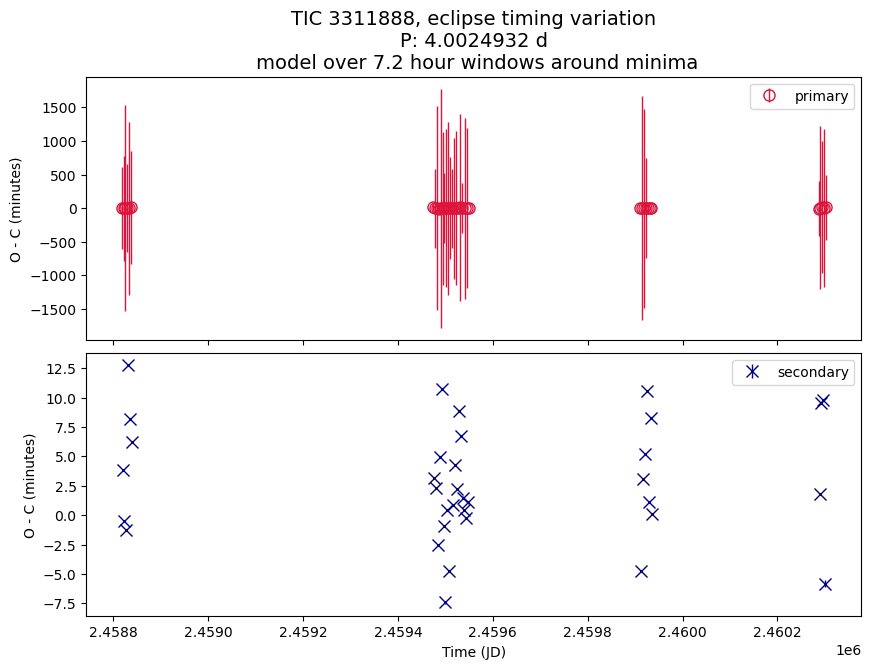

In [144]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# for comparison with archival data
in_df_primary['MHJD_like'] = in_df_primary['epoch'] - 2400000  
in_df_primary['num_cycles'] = (in_df_primary['epoch'] - 2439061.4646) / period

# in_df_primary_all = in_df_primary
# in_df_primary = in_df_primary[in_df_primary.shift_mins > -20]  # filter out outliers

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    
    # in_df_secondary_all = in_df_secondary
    # in_df_secondary = in_df_secondary[in_df_secondary.shift_mins > -20]  # filter out outliers
    # in_df_secondary = in_df_secondary[in_df_secondary.shift_mins < 90]  # filter out outliers
    
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d\n model over 7.2 hour windows around minima", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

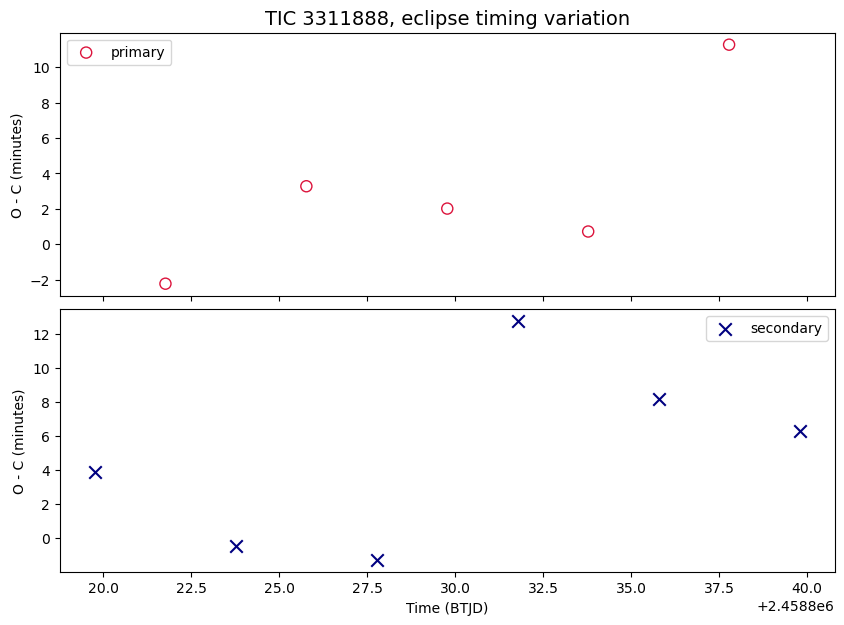

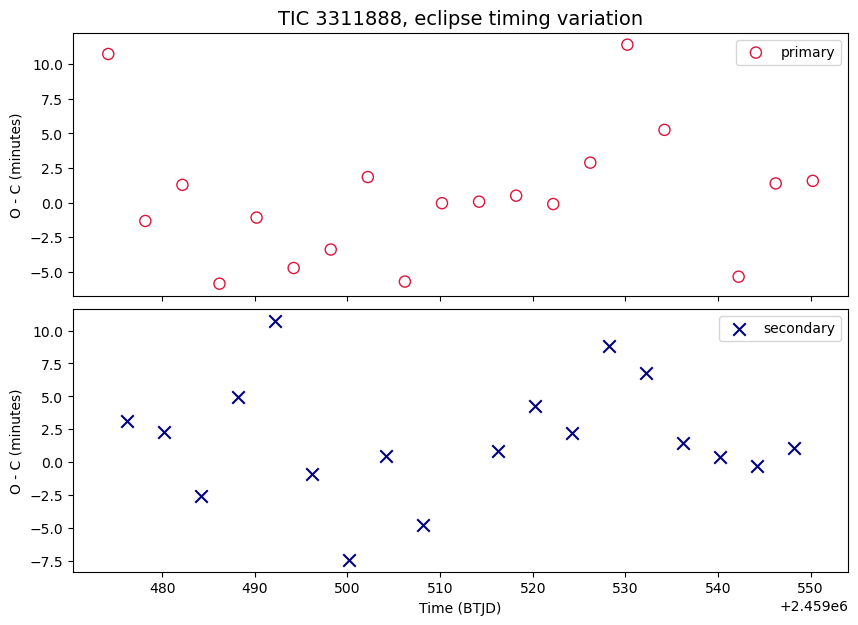

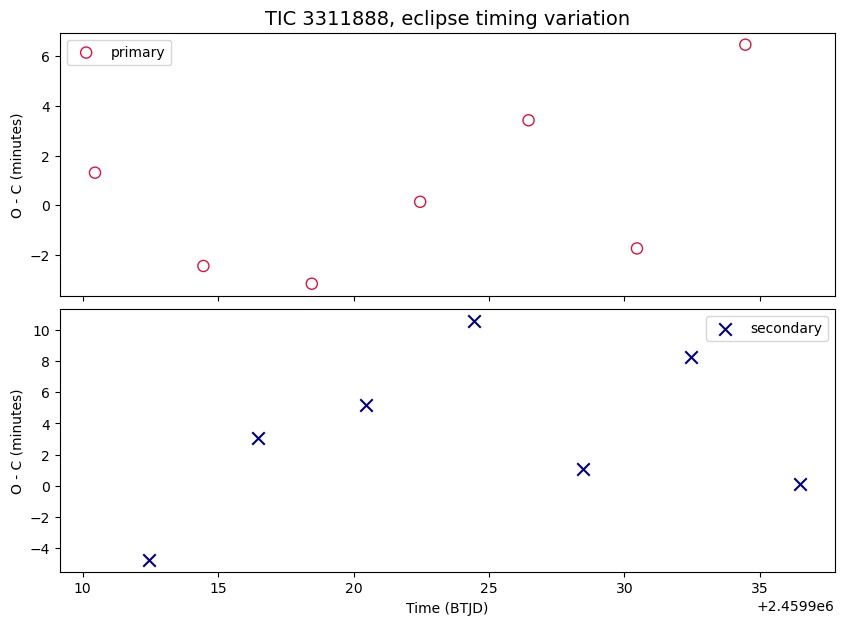

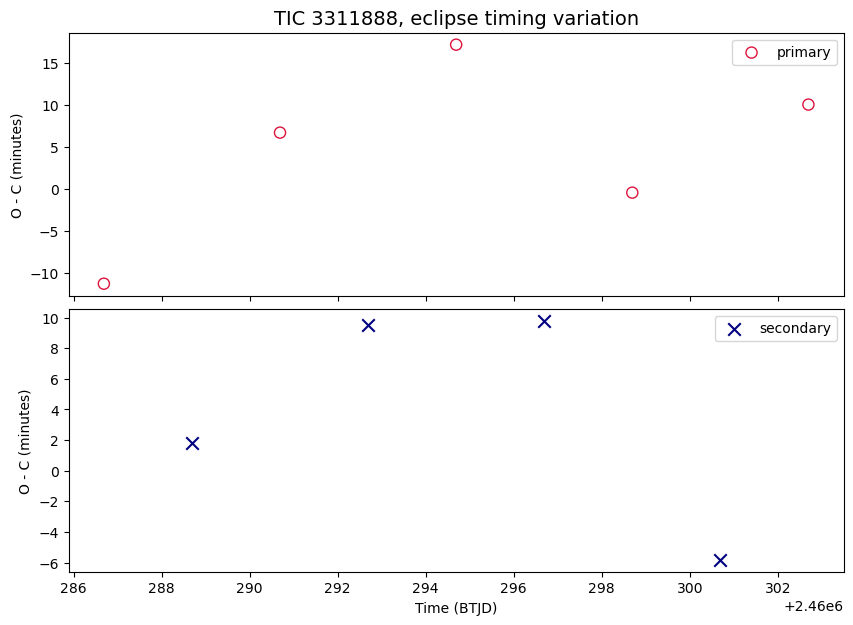

In [146]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (2458818, 2459000),
    (2459400, 2459600),
    (2459900, 2460000),
    (2460000, 2460400),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## Compare TESS ETVs with archival results from the paper

Extending the paper's figure 1 with TESS ETV

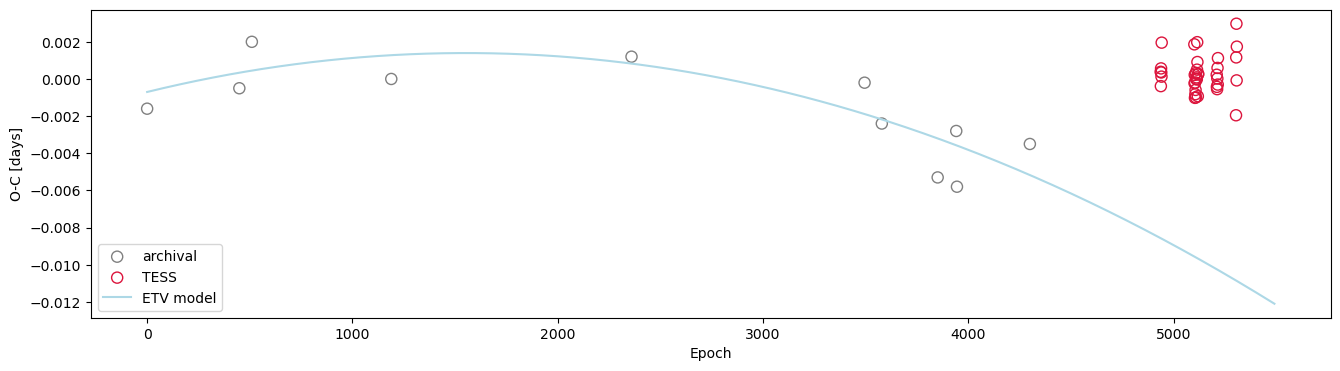

In [147]:
from io import StringIO

# Table 1 of the paper,
# MHJD_like: JD - 2400000
# O-C: in days
df_etv_archival = pd.read_csv(StringIO("""\
MHJD_like,m.e.,Epoch,O-C,Source
39061.4630,20,0.0,-0.0016,1
40858.5835,15,449.0,-0.0005,2
41102.7381,16,510.0,0.0020,3
43820.4290,10,1189.0,-0.0000,4
48503.347,18,2359.0,0.0012,5
53046.1756,9,3494.0,-0.0002,6
53382.3826,5,3578.0,-0.0024,7
54471.0581,4,3850.0,-0.0053,8
54833.2860,5,3940.5,-0.0028,9
54847.2920,15,3944.0,-0.0058,10
56268.1794,9,4299.0,-0.0035,8
"""))


ax = plt.figure(figsize=(16, 4)).gca()
ax.scatter(df_etv_archival['Epoch'], df_etv_archival['O-C'], 
           marker = 'o', s=8**2, color = 'None', edgecolor = 'gray', label="archival");

# error is too large
# ax.errorbar(in_df_primary['num_cycles'], in_df_primary['t0'], yerr = in_df_primary['stdv_t0'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="TESS")
ax.scatter(in_df_primary['num_cycles'], in_df_primary['t0'],
           marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="TESS")

def etv_model_func(epoch):
    model_c = 2439061.4646 + 4.0024932 * epoch  # eq 1
    model_o = 2439061.4639 + 4.0024959 * epoch - 0.87e-9 * epoch ** 2 # eq 2
    return model_o - model_c

model_epoch = np.arange(0, 5500, step=10)
model_oc = etv_model_func(model_epoch)

ax.plot(model_epoch, model_oc, c="lightblue", label="ETV model");

ax.set_ylabel("O-C [days]")
ax.set_xlabel("Epoch")
ax.legend();

Reference the ETV result using a large eclipse window (28.8 hour) for moedling

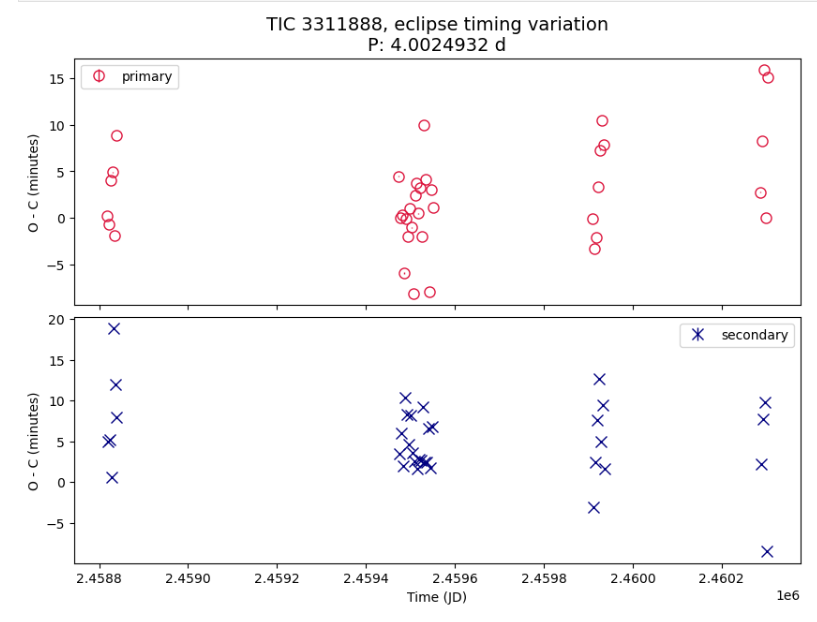

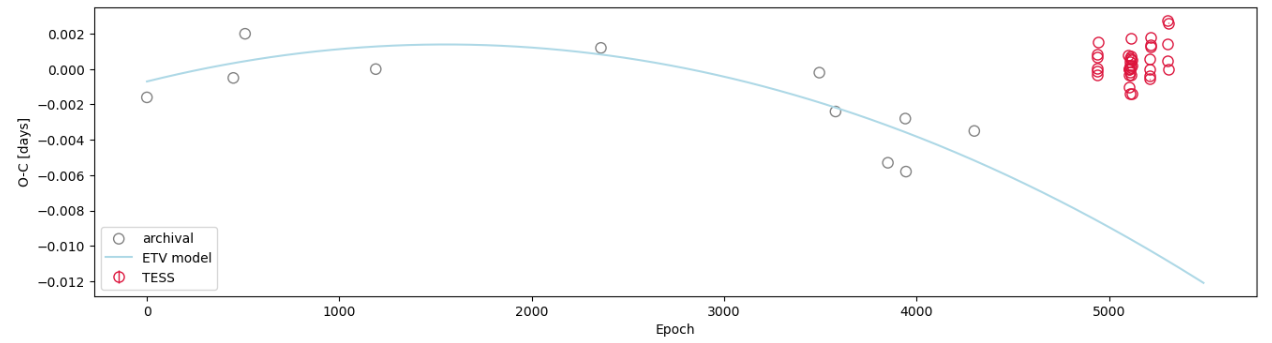


### Try to see if the minimum from fitting multiple consecutive eclipses will have signficant change

No sigifincant change. The O-C below, ~`0.00047` d, is roughly the same as the results from fiftting individual eclipses.
The expected O-C decrease is not proudced.

1210 24.168929216451943


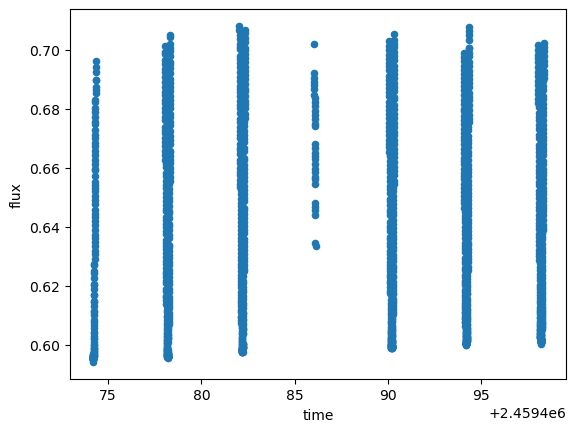

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.56it/s]


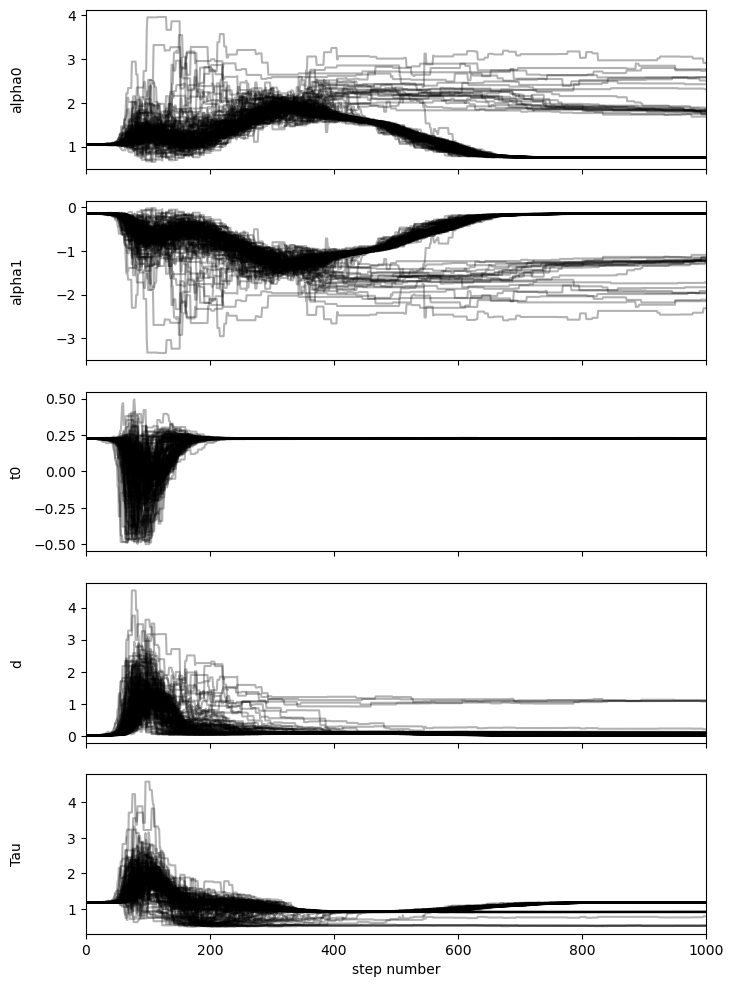

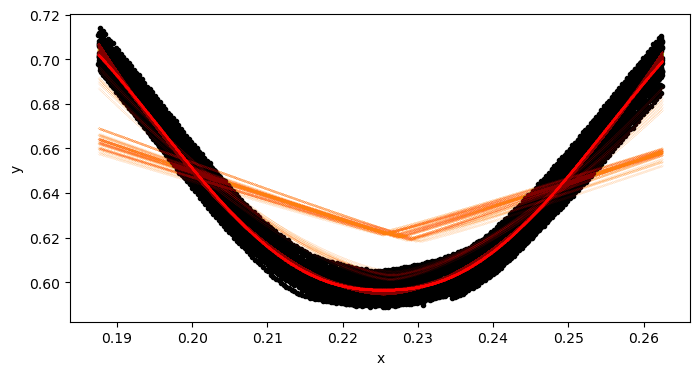

In [169]:
# averaging out eclipses of ~1 TESS sector, about 7 eclipses 
_df_p_subset = data_primary[(2459400 < data_primary.time) & (data_primary.time <2459500)]
print(len(_df_p_subset), _df_p_subset.time.max() - _df_p_subset.time.min())
_df_p_subset.plot(x="time", y="flux", kind="scatter");
plt.show();


_fit_results = etv_functions.run_mcmc_initial_fit(data_primary, [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau], nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)

_mean_t0_subset = _fit_results[2]

In [168]:
print(_fit_results)
print(_mean_t0_subset)
_oc_subset_days = (_mean_t0_subset - mean_t0) * period  # from normalized phase to days
_oc_subset_min = _oc_subset_days * 24 * 60
print(_oc_subset_days, _oc_subset_min)

(0.794611780670774, -0.1979843983652239, 0.2253944193086855, 0.03169039711303489, 1.0818148365721179)
0.2253944193086855
-0.0004711187541810048 -0.678411006020647


In [22]:
from astropy.time import Time
from astropy.coordinates import SkyCoord


epoch_min_ref = 2439061.4646  # from the paper, in HJD, the lc has been converted to HJD
# period = 4.0024932  # from the paper

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
# t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period

# TESS-EB 2022ApJS, based on a single sector (19)
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ65ea02e82d11d2&-out.add=.&-source=J/ApJS/258/16/tess-ebs&recno=2190&-out.orig=o
epoch_min_tesseb = lke.to_hjd_utc(Time(1817.773518, format="btjd"), SkyCoord(ra=82.42770711954, dec=35.37502715056, unit=(u.deg, u.deg), frame="icrs")).value

o_c_tesseb = epoch_min_tesseb - (epoch_min_ref + round((epoch_min_tesseb - epoch_min_ref) / period) * period)
print("O-C (days) from TESS-EB: ", o_c_tesseb)


# ---

# TESS OBA-type EB, 2021 A&A (also from sector 19(
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ65e9fff5273d6e&-out.add=.&-source=J/A%2bA/652/A120/eb-cat&recno=410
epoch_min_2021AnA = lke.to_hjd_utc(Time(1817.76098, format="btjd"), SkyCoord(ra=82.42770711954, dec=35.37502715056, unit=(u.deg, u.deg), frame="icrs")).value

o_c_2021AnA = epoch_min_2021AnA - (epoch_min_ref + round((epoch_min_2021AnA - epoch_min_ref) / period) * period)
print("O-C (days) from 2021A&A: ", o_c_2021AnA)


O-C (days) from TESS-EB:  0.0016420199535787106
O-C (days) from 2021A&A:  -0.010895980522036552


Adding  O-C  derived 2 published TESS results:

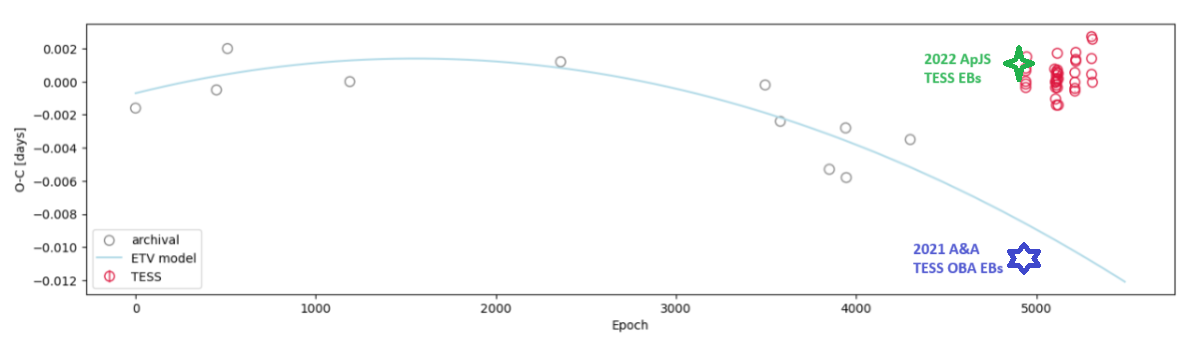

## make a periodogram 

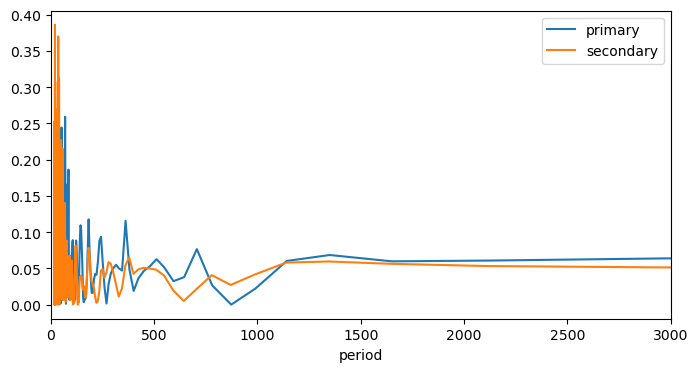

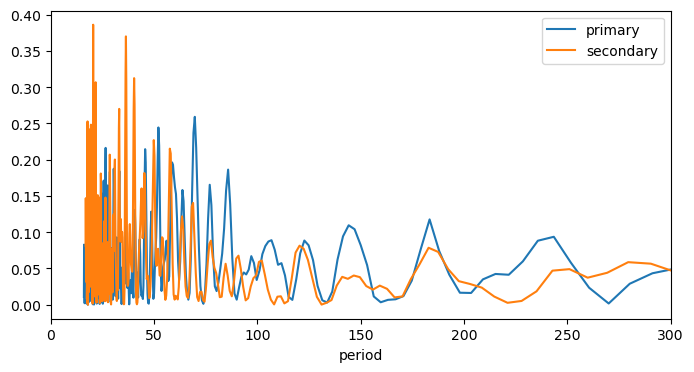

In [148]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 300)
    plt.show()

## Results Summary

In [171]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "Cannot produce the predicted O-C decease in 2013A&A. The cosh model seems to be more V-shaped than the data. There result does not change after using a 2nd model with flatter bottom."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                         3311888
has_etv                                                                                                                                                                                           ?
comments     Cannot produce the predicted O-C decease in 2013A&A. The cosh model seems to be more V-shaped than the data. There result does not change after using a 2nd model with flatter bottom.
period                                                                                                                                                                                     4.002493
depth_pct_p                                                                                                                                                                                   14.93
depth_pct_s                                                                                                                                                                                   10.65
epoch_p                                                                                                                                                                              2458813.768542
epoch_s                                                                                                                                                                              2458815.769789
num_sectors                                                                                                                                                                                       6
time_span                                                                                                                                                                                   1496.56
time_start                                                                                                                                                                               2458816.09
time_end                                                                                                                                                                                 2460312.65


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
3311888,?,Cannot produce the predicted O-C decease in 2013A&A. The cosh model seems to be more V-shaped than the data. There result does not change after using a 2nd model with flatter bottom.,4.0024932,14.93,10.65,2458813.768542,2458815.7697886,6,1496.56,2458816.09,2460312.65

